<a href="https://colab.research.google.com/github/db-d2/stat4243_proj2/blob/main/slime_mold_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Slime Mold Spatio-Temporal — Week 1 Starter

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reproducibility: Seed Control
We set a global random seed for `random`, `numpy`, and `torch` to ensure that data splits, weight initializations, and training dynamics are reproducible.

In [ ]:
#@title Setup (optional installs)
%pip install tifffile h5py scikit-image tqdm zarr


Note: you may need to restart the kernel to use updated packages.


In [ ]:
#@title Imports & seed
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # I hate anaconda

try:
    import tifffile as tiff
except Exception:
    tiff = None
try:
    import h5py
except Exception:
    h5py = None

def set_seed(seed=7):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(7)
DEVICE

'cuda'

# Project Overview & Approach

## Problem Statement
The goal of this project is to predict the "aggregation center" of *Dictyostelium discoideum* (slime mold) cells based on early video frames of their movement. As these cells starve, they signal each other with cAMP waves and aggregate into a multicellular mound. We aim to predict the final (x, y) coordinates of this mound using only the first 50 frames of the movie.

## Approach
1.  **Data Engineering:** We preprocess all raw movies offline into standardized tensors.
2.  **Modeling:** We implement and compare four distinct deep learning architectures:
    *   **CNN-LSTM:** A spatio-temporal model that extracts spatial features with a 2D CNN and aggregates temporal dynamics with an LSTM.
    *   **Tiny3DCNN:** A volumetric model using 3D convolutions to capture space and time simultaneously.
    *   **LastFrameCNN:** A static baseline that predicts solely from the final available frame, testing the necessity of temporal history.
    *   **Hopfield-Attention (Bonus):** A modern attention-based architecture that retrieves "prototypical" aggregation patterns.
3.  **Evaluation:** We assess models based on Mean Distance Error (in microns), robustness to limited temporal context, robustness to reduced image resolution, and generalization to a held-out test set.

## Data Description & Preprocessing
*   **Source:** Time-lapse microscopy movies of *Dictyostelium* aggregation (Tiff/Zarr formats).
*   **Channels:** Single-channel grayscale (fluorescence intensity).
*   **Preprocessing Pipeline:**
    *   **Denoising:** Gaussian smoothing ($\sigma=1.0$) is applied to reduce sensor noise.
    *   **Resolution Standardization:** All movies are resized to a physical resolution of **2.0 µm/pixel** and a spatial dimension of **320x320**.
    *   **Normalization:** Pixel intensities are normalized to [0, 1].
    *   **Labeling (Masks):** The "Ground Truth" aggregation center is computed as the center of mass of the segmented cells (Otsu thresholding mask [8]) in the final 5 frames of the movie.
    *   **Temporal Padding:** All sequences are padded or truncated to a fixed length of **50 frames**.
*   **Why T=50?** We restrict the input to the first 50 frames to simulate an early prediction task. Biologically, aggregation takes many hours. By using only the initial phase (approx. first 10-15% of the process), we test the model's ability to detect early signaling waves before the physical mound is clearly visible to the naked eye.
*   **Reproducibility:** A global random seed is set for Python, NumPy, and PyTorch to ensure consistent data splits and weight initialization.

## Code Availability
The code for this project is available at: [GitHub Repository Link]

## 1) Load data (choose a reader and set `DATA_PATH`)

In [ ]:
#@title Readers
DATA_PATH = "/content/drive/MyDrive/STAT4243/proj2/Data" # adjust to your own data path

def read_npy(path):
    return np.load(path)

def read_h5(path, key="images"):
    assert h5py is not None, "install h5py"
    import h5py as _h5
    with _h5.File(path, "r") as f:
        arr = f[key][:]
    return np.array(arr)

def read_tiff_stack(path):
    assert tiff is not None, "install tifffile"
    return np.asarray(tiff.imread(path))

# raw = read_npy(DATA_PATH)
# raw = read_h5(DATA_PATH, key="images")
# raw = read_tiff_stack(DATA_PATH)

# synthetic placeholder
def synthetic_demo(T=60, H=64, W=64):
    x = np.zeros((T, H, W), np.float32)
    for t in range(T):
        cx = int(H / 2 + (10 + 5 * np.sin(t / 8)) * np.cos(t / 10))
        cy = int(W / 2 + (10 + 5 * np.sin(t / 8)) * np.sin(t / 10))
        x[t, cx % H, cy % W] = 1.0
        x[t] = np.clip(x[t] + 0.1 * np.random.randn(H, W).astype(np.float32), 0, 1)
    return x

raw = synthetic_demo()
raw.shape

(60, 64, 64)

shape: (60, 64, 64) min/max: 0.0 1.0


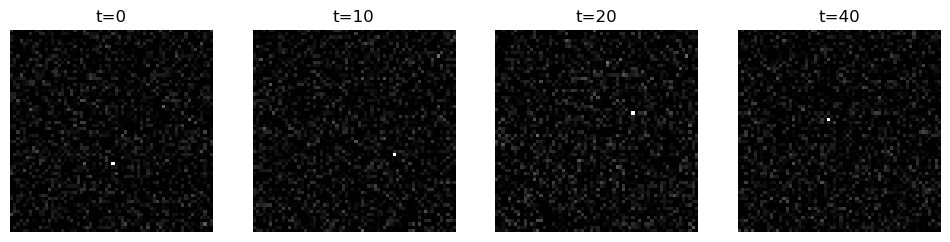

In [ ]:
#@title Inspect & visualize a few frames
print("shape:", raw.shape, "min/max:", float(raw.min()), float(raw.max()))

def show_frames(arr, frames=(0, 10, 20, 40)):
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, len(frames), figsize=(12, 3))
    for ax, t in zip(axs, frames):
        ax.imshow(arr[t] if arr.ndim == 3 else arr[t, 0], cmap="gray")
        ax.set_title(f"t={t}")
        ax.axis("off")
    plt.show()

show_frames(raw)

## 2) Dataset/Dataloader (sliding window next-frame prediction)

In [ ]:
#@title Dataset & loaders
from torch.utils.data import Dataset, DataLoader, random_split

class WindowedFrames(Dataset):
    def __init__(self, arr, K=4):
        if arr.ndim == 3:
            arr = arr[:, None, ...]
        self.arr = arr.astype(np.float32)
        self.K = K

    def __len__(self):
        return self.arr.shape[0] - self.K

    def __getitem__(self, i):
        x = torch.from_numpy(self.arr[i : i + self.K])     # (K,1,H,W)
        y = torch.from_numpy(self.arr[i + self.K])       # (1,H,W)
        return x, y

K = 4
ds = WindowedFrames(raw, K)
n_tr = int(0.7 * len(ds))
n_val = int(0.15 * len(ds))
n_te = len(ds) - n_tr - n_val

tr, val, te = random_split(ds, [n_tr, n_val, n_te], generator=torch.Generator().manual_seed(0))
tr_loader = DataLoader(tr, batch_size=16, shuffle=True)
val_loader = DataLoader(val, batch_size=32)
te_loader = DataLoader(te, batch_size=32)

len(tr), len(val), len(te)

(39, 8, 9)

## 3) Baseline model (Conv3D encoder → Conv2D head)

ep 05  tr 0.0187  val 0.0160
ep 10  tr 0.0048  val 0.0041
ep 15  tr 0.0042  val 0.0041
ep 20  tr 0.0037  val 0.0038


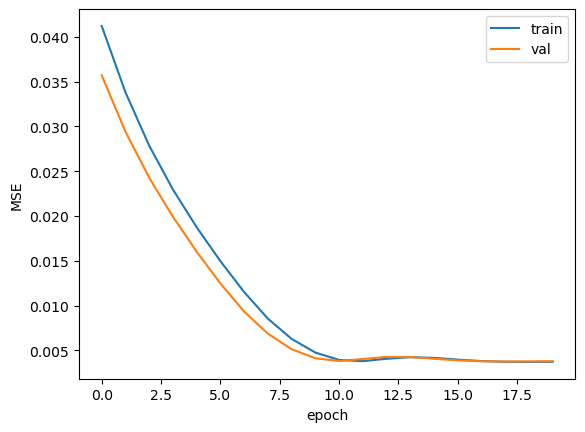

In [ ]:
#@title Model, train, eval
class TinyCNN(nn.Module):
    def __init__(self, K):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=(K, 3, 3), padding=(0, 1, 1)),
            nn.ReLU()
        )
        self.head = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, 1)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)   # (B,1,K,H,W)
        z = self.enc(x).squeeze(2) # (B,8,H,W)
        return self.head(z)

model = TinyCNN(K).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

def train_epoch(model, loader):
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        total += loss_fn(model(xb), yb).item() * xb.size(0)
    return total / len(loader.dataset)

hist_tr, hist_val = [], []
for ep in range(1, 21):
    tr = train_epoch(model, tr_loader)
    va = evaluate(model, val_loader)
    hist_tr.append(tr)
    hist_val.append(va)
    if ep % 5 == 0:
        print(f"ep {ep:02d}  tr {tr:.4f}  val {va:.4f}")

plt.figure()
plt.plot(hist_tr, label="train")
plt.plot(hist_val, label="val")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.show()

## 4) Qualitative prediction

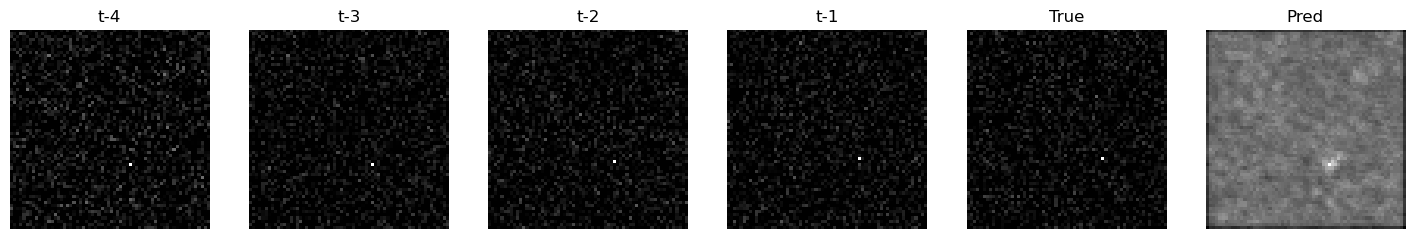

In [ ]:
#@title Show one prediction
@torch.no_grad()
def show_example(i=0):
    xb, yb = ds[i]
    pred = model(xb.unsqueeze(0).to(DEVICE)).cpu().squeeze().numpy()
    true = yb.squeeze().numpy()
    hist = xb[:, 0].numpy()
    cols = hist.shape[0] + 2
    fig, axs = plt.subplots(1, cols, figsize=(3 * cols, 3))
    for k in range(hist.shape[0]):
        axs[k].imshow(hist[k], cmap="gray")
        axs[k].set_title(f"t-{hist.shape[0]-k}")
        axs[k].axis("off")
    axs[-2].imshow(true, cmap="gray")
    axs[-2].set_title("True")
    axs[-2].axis("off")
    axs[-1].imshow(pred, cmap="gray")
    axs[-1].set_title("Pred")
    axs[-1].axis("off")
    plt.show()

show_example(5)


## 5) Extensions
- Predict velocity `frame[t+1]-frame[t]` (change target).
- Try L1/Huber loss and a cosine LR schedule.
- Make the split **by time** (first 70% train, last 30% test).
- Replace Conv3D with per-frame Conv2D + LSTM.
- Add Sobel edges as extra channels.
- Implement early stopping.


## Data Engineering (Offline Preprocessing)

This section implements an approach with physical and temporal standardization, plus **Spatio-Temporal Augmentation**:

1.  **File Selection:** We process only the **Raw** movie files (ignoring pre-subsampled versions).
2.  **Standardization:**
    *   **Time:** All movies standardized to **5-minute intervals**.
    *   **Space:** All movies resized to **2.0 µm/pixel** and cropped/padded to **320x320**.
3.  **Augmentation (The Multiplier):**
    *   **Temporal:** We extract multiple "sliding windows" from the early-to-mid phase of each movie (e.g., starting at t=0, t=5, t=10...). This allows the model to learn from different stages of the aggregation process while avoiding the "too easy" late stages.
    *   **Spatial:** For *each* temporal window, we generate **8 variations** (4 rotations $\times$ 2 flips).
    *   **Result:** A single movie can yield 40+ unique training samples, solving our small data problem.
4.  **Labeling:** Ground Truth (Center of Mass) is calculated and transformed to match each augmentation.
5.  **Save:** Store processed tensors (`.pt`) to disk.

In [ ]:
#@title Imports & Configuration
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
from skimage.filters import threshold_otsu, gaussian
from skimage.transform import resize

# Check for tifffile
try:
    import tifffile
except ImportError:
    print("tifffile not found. Please install it: pip install tifffile")

# Setup Device & Seed
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_seed()

# ==========================================
# CONFIGURATION
# ==========================================
DATA_ROOT = "/content/drive/MyDrive/STAT4243/proj2/Data"               # Input folder (raw .tif movies)
OUTPUT_PATH = Path("Processed_Data")    # Output folder (clean .pt tensors)
QC_PATH = OUTPUT_PATH / "QC_Images"     # Folder for sanity check images
RESULTS_PATH = Path("Results")          # Output folder for JSON stats
FIGURES_PATH = RESULTS_PATH / "Figures" # Output folder for plots

OUTPUT_PATH.mkdir(exist_ok=True)
QC_PATH.mkdir(exist_ok=True)
RESULTS_PATH.mkdir(exist_ok=True)
FIGURES_PATH.mkdir(exist_ok=True)

# Standardization Targets
TARGET_SIZE = (320, 320)        # Target spatial dimension (pixels)
TARGET_RES_UM = 2.0             # Target physical resolution (microns per pixel)
TARGET_TIME_INTERVAL = 5.0      # Target temporal interval (minutes)

FRAME_LIMIT = 50                # Input: First 50 frames (after subsampling)
DENOISE_SIGMA = 1.0             # Gaussian blur sigma for denoising

# Augmentation Settings
TEMP_AUG_STRIDE = 5             # Start a new window every 5 frames (25 mins)
TEMP_AUG_MAX_START = 30         # Don't start windows later than frame 30 (150 mins)


Using device: cuda


In [ ]:
#@title Data Engineering Function
def process_and_save_data():
    """
    Scans Data/ folder for movies (zarr/tif), matches them with metadata,
    standardizes time/resolution, generates labels, AUGMENTS data (Spatial + Temporal), and saves .pt files.
    """
    print("--- Starting Data Engineering ---")

    # 1. Load Metadata
    excel_path = "/content/drive/MyDrive/STAT4243/proj2/Data/experiment_info.xlsx"
    if not os.path.exists(excel_path):
        for ext in [".tsv", ".csv"]:
            if os.path.exists(f"experiment_info{ext}"):
                excel_path = f"experiment_info{ext}"
                break

    if os.path.exists(excel_path):
        if excel_path.endswith(".xlsx"):
            df = pd.read_excel(excel_path)
        else:
            sep = '\t' if excel_path.endswith('.tsv') else ','
            df = pd.read_csv(excel_path, sep=sep)
        df['expt'] = df['expt'].astype(str)
    else:
        print(f"Warning: Metadata file not found. Using defaults.")
        df = pd.DataFrame(columns=['expt', 'pixel_size (um)', 'time_interval (min)'])

    # 2. Discover Files
    data_path = Path(DATA_ROOT)
    candidate_files = []
    for p in data_path.rglob("*"):
        if p.name.startswith("."): continue
        if "t_subsampled" in str(p): continue # Skip subsampled duplicates
        if p.suffix in [".tif", ".tiff"]:
            candidate_files.append(p)
        elif p.suffix == ".zarr" and p.is_dir():
            candidate_files.append(p)

    print(f"Found {len(candidate_files)} candidate movie files (excluding subsampled).")

    processed_stems = set()
    processed_files = []

    for file_path in candidate_files:
        if file_path.stem in processed_stems:
            print(f"Skipping duplicate: {file_path.name}")
            continue

        # 3. Match Metadata
        pixel_size = 1.0
        time_interval = 5.0
        expt_name = "unknown"

        # Logic update: Use parent directory mapping as primary source
        parent_dir = file_path.parent.name

        # Explicit mapping based on directory structure
        dir_map = {
            "mixin_test44": "mixin44",
            "mixin_test57": "mixin57",
            "mixin_test64": "mixin64"
        }

        if parent_dir in dir_map:
            expt_name = dir_map[parent_dir]
        else:
            # Fallback: try to find mixinXX in parent dir or filename
            import re
            # Check parent dir first
            match = re.search(r"(mixin\d+)", parent_dir)
            if match:
                expt_name = match.group(1)
            else:
                # Check filename
                match = re.search(r"(mixin\d+)", file_path.name)
                if match:
                    expt_name = match.group(1)

        # Retrieve physical/temporal params from metadata dataframe
        if not df.empty and expt_name != "unknown":
            row = df[df['expt'] == expt_name]
            if not row.empty:
                pixel_size = float(row.iloc[0].get('pixel_size (um)', 1.0))
                time_interval = float(row.iloc[0].get('time_interval (min)', 5.0))

        print(f"Processing {file_path.name} (Expt: {expt_name})...")
        print(f"  Metadata -> Pixel Size: {pixel_size} um, Interval: {time_interval} min")

        # 4. Load Movie
        movie_raw = None
        try:
            if file_path.suffix in [".tif", ".tiff"]:
                movie_raw = tifffile.imread(str(file_path))
            elif file_path.suffix == ".zarr":
                import zarr
                z = zarr.open(str(file_path), mode='r')
                movie_raw = np.array(z)
        except Exception as e:
            print(f"  Error loading {file_path.name}: {e}")
            continue

        if movie_raw is None: continue

        print(f"  Raw Shape: {movie_raw.shape}, Range: [{movie_raw.min()}, {movie_raw.max()}]")

        # Handle Dimensions (Robust 4D handling)
        movie_raw = np.squeeze(movie_raw)
        if movie_raw.ndim == 4:
            # Heuristic: Channels are usually the smallest dimension (e.g., 1, 2, 3)
            # Time, Height, Width are usually larger.
            shape = movie_raw.shape
            # Check for (T, C, H, W) -> Axis 1 is small
            if shape[1] <= 4 and shape[2] > 10 and shape[3] > 10:
                print(f"  Detected (T, C, H, W) format. Max projecting over channel (axis 1).")
                movie_raw = np.max(movie_raw, axis=1)
            # Check for (T, H, W, C) -> Axis 3 is small
            elif shape[3] <= 4 and shape[1] > 10 and shape[2] > 10:
                print(f"  Detected (T, H, W, C) format. Max projecting over channel (axis 3).")
                movie_raw = np.max(movie_raw, axis=3)
            else:
                print(f"  Warning: Ambiguous 4D shape {shape}. Defaulting to max over axis 1.")
                movie_raw = np.max(movie_raw, axis=1)

        if movie_raw.ndim != 3:
            print(f"  Skipping: Invalid dimensions after squeeze/proj: {movie_raw.shape}")
            continue

        # 5. Temporal Standardization
        stride = int(round(TARGET_TIME_INTERVAL / time_interval))
        if stride < 1: stride = 1
        if stride > 1: movie_raw = movie_raw[::stride]

        # 6. Physical Standardization
        scale_factor = pixel_size / TARGET_RES_UM
        # Denoise
        movie_denoised = gaussian(movie_raw, sigma=(0, DENOISE_SIGMA, DENOISE_SIGMA), preserve_range=True)
        tensor_movie = torch.tensor(movie_denoised.astype(np.float32)).unsqueeze(0)

        curr_h, curr_w = tensor_movie.shape[2], tensor_movie.shape[3]
        new_h, new_w = int(curr_h * scale_factor), int(curr_w * scale_factor)

        print(f"  Resizing: {curr_h}x{curr_w} -> {new_h}x{new_w} (Scale: {scale_factor:.2f})")

        if new_h != curr_h or new_w != curr_w:
            tensor_resized = F.interpolate(tensor_movie, size=(new_h, new_w), mode='bilinear', align_corners=False)
        else:
            tensor_resized = tensor_movie
        tensor_resized = tensor_resized.squeeze(0)

        # Crop/Pad to TARGET_SIZE
        T, H, W = tensor_resized.shape
        target_h, target_w = TARGET_SIZE
        final_tensor = torch.zeros((T, target_h, target_w), dtype=torch.float32)

        src_y, src_x = max(0, (H - target_h) // 2), max(0, (W - target_w) // 2)
        dst_y, dst_x = max(0, (target_h - H) // 2), max(0, (target_w - W) // 2)
        copy_h, copy_w = min(H, target_h), min(W, target_w)

        final_tensor[:, dst_y:dst_y+copy_h, dst_x:dst_x+copy_w] = \
            tensor_resized[:, src_y:src_y+copy_h, src_x:src_x+copy_w]

        # Check for empty image (black)
        if final_tensor.max() <= final_tensor.min() + 1e-6:
            print(f"  Warning: Processed tensor is empty/flat (Range: {final_tensor.min()} - {final_tensor.max()}). Skipping.")
            continue

        # 7. Generate Base Label
        last_frames = final_tensor[-5:].mean(dim=0).numpy()

        # Reverted to Min-Max Normalization (Experiment showed Percentile Norm hurt performance)
        last_frames_norm = (last_frames - last_frames.min()) / (last_frames.max() - last_frames.min() + 1e-6)

        try:
            thresh = threshold_otsu(last_frames_norm)
            binary = last_frames_norm > thresh
            y_coords, x_coords = np.nonzero(binary)
            if len(y_coords) == 0: raise ValueError("No activation")
            center_y, center_x = np.mean(y_coords), np.mean(x_coords)
            norm_y, norm_x = center_y / target_h, center_x / target_w
        except Exception as e:
            print(f"  Label generation failed: {e}")
            continue

        # 8. SPATIO-TEMPORAL AUGMENTATION

        # A. Temporal Sliding Window
        T_total = final_tensor.shape[0]
        start_indices = list(range(0, TEMP_AUG_MAX_START + 1, TEMP_AUG_STRIDE))
        start_indices = [t for t in start_indices if t < T_total]
        if not start_indices: start_indices = [0]

        print(f"  Generating {len(start_indices)} temporal windows x 16 spatial augs (8 clean + 8 masked)...")

        for t_start in start_indices:
            # Extract Window
            base_seq = final_tensor[t_start : t_start + FRAME_LIMIT]

            # Pad time if shorter
            if base_seq.shape[0] < FRAME_LIMIT:
                pad_len = FRAME_LIMIT - base_seq.shape[0]
                padding = torch.zeros((pad_len, target_h, target_w), dtype=base_seq.dtype)
                base_seq = torch.cat([base_seq, padding], dim=0)

            # Reverted to Min-Max Normalization
            base_seq = (base_seq - base_seq.min()) / (base_seq.max() - base_seq.min() + 1e-6)

            # B. Spatial Augmentation (8 versions)
            augmentations = [
                (0, False), (1, False), (2, False), (3, False),
                (0, True),  (1, True),  (2, True),  (3, True)
            ]

            for i, (k, do_flip) in enumerate(augmentations):
                # Apply Flip
                aug_seq = base_seq.clone()
                aug_x, aug_y = norm_x, norm_y

                if do_flip:
                    aug_seq = torch.flip(aug_seq, [2])
                    aug_x = 1.0 - aug_x

                # Apply Rotation
                if k > 0:
                    aug_seq = torch.rot90(aug_seq, k, [1, 2])
                    for _ in range(k):
                        new_x = aug_y
                        new_y = 1.0 - aug_x
                        aug_x, aug_y = new_x, new_y

                # --- 1. Save Clean Version ---
                save_name = f"{file_path.stem}_t{t_start}_aug{i}"
                save_file = OUTPUT_PATH / f"{save_name}.pt"

                torch.save({
                    'x': aug_seq.float(),
                    'y': torch.tensor([aug_x, aug_y]).float(),
                    'name': save_name,
                    'expt': expt_name
                }, save_file)
                processed_files.append(save_file)

                # --- 2. Save Tube Masked Version (New) ---
                # Generate random mask (20-50% of image size)
                mask_h = np.random.randint(target_h // 5, target_h // 2)
                mask_w = np.random.randint(target_w // 5, target_w // 2)
                y_pos = np.random.randint(0, target_h - mask_h)
                x_pos = np.random.randint(0, target_w - mask_w)

                aug_seq_masked = aug_seq.clone()
                # Apply mask across all time steps (Tube Masking)
                aug_seq_masked[:, y_pos:y_pos+mask_h, x_pos:x_pos+mask_w] = 0.0

                save_name_masked = f"{file_path.stem}_t{t_start}_aug{i}_masked"
                save_file_masked = OUTPUT_PATH / f"{save_name_masked}.pt"

                torch.save({
                    'x': aug_seq_masked.float(),
                    'y': torch.tensor([aug_x, aug_y]).float(), # Label is SAME
                    'name': save_name_masked,
                    'expt': expt_name
                }, save_file_masked)
                processed_files.append(save_file_masked)

                # QC Plot (Only for first window, first aug)
                if t_start == 0 and i == 0:
                    plt.figure(figsize=(8,4))

                    # Plot Clean
                    plt.subplot(1,2,1)
                    frame_idx = min(50, aug_seq.shape[0]-1)
                    plt.imshow(aug_seq[frame_idx], cmap='gray')
                    plt.scatter(aug_x * target_w, aug_y * target_h, c='red', marker='x', s=100)
                    plt.title(f"Clean\n{save_name}")
                    plt.axis('off')

                    # Plot Masked
                    plt.subplot(1,2,2)
                    plt.imshow(aug_seq_masked[frame_idx], cmap='gray')
                    plt.scatter(aug_x * target_w, aug_y * target_h, c='red', marker='x', s=100)
                    plt.title(f"Tube Masked\n{save_name_masked}")
                    plt.axis('off')

                    plt.savefig(QC_PATH / f"{save_name}_QC.png")
                    plt.close()

        processed_stems.add(file_path.stem)

    print(f"Processed {len(processed_files)} samples (from {len(processed_stems)} movies).")
    return processed_files

# Run Data Engineering
all_pt_files = process_and_save_data()

--- Starting Data Engineering ---
Found 6 candidate movie files (excluding subsampled).
Processing 2024-01-17_ERH_23hr_ERH Red FarRed.tif (Expt: mixin44)...
  Metadata -> Pixel Size: 2.41 um, Interval: 5.0 min
  Raw Shape: (100, 32, 256, 256), Range: [0, 59040]
Found 6 candidate movie files (excluding subsampled).
Processing 2024-01-17_ERH_23hr_ERH Red FarRed.tif (Expt: mixin44)...
  Metadata -> Pixel Size: 2.41 um, Interval: 5.0 min
  Raw Shape: (100, 32, 256, 256), Range: [0, 59040]
  Resizing: 256x256 -> 308x308 (Scale: 1.21)
  Generating 7 temporal windows x 16 spatial augs (8 clean + 8 masked)...
  Resizing: 256x256 -> 308x308 (Scale: 1.21)
  Generating 7 temporal windows x 16 spatial augs (8 clean + 8 masked)...
Skipping duplicate: 2024-01-17_ERH_23hr_ERH Red FarRed.zarr
Processing 2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25.tif (Expt: mixin57)...
  Metadata -> Pixel Size: 2.41 um, Interval: 1.0 min
Skipping duplicate: 2024-01-17_ERH_23hr_ERH Red FarRed.zarr
Processing 20

## Dataset & Baselines

We load the pre-processed `.pt` files and establish a "Mean Position" baseline.


In [ ]:
#@title Dataset & Baselines
class DictySimpleDataset(Dataset):
    def __init__(self, file_list, target_len=50, use_sobel=True, target_size=None):
        self.file_list = file_list
        self.target_len = target_len
        self.use_sobel = use_sobel
        self.target_size = target_size # Expected (H, W)

    def _compute_sobel(self, x):
        # x: (T, 1, H, W)
        # Sobel kernels
        k_x = torch.tensor([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]]).view(1, 1, 3, 3)
        k_y = torch.tensor([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]]).view(1, 1, 3, 3)

        # Pad for 'same' convolution
        x_pad = F.pad(x, (1, 1, 1, 1), mode='replicate')

        gx = F.conv2d(x_pad, k_x)
        gy = F.conv2d(x_pad, k_y)

        mag = torch.sqrt(gx**2 + gy**2 + 1e-6)
        # Normalize roughly (max gradient of 0-1 image is ~4)
        return mag / 4.0

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        data = torch.load(self.file_list[idx])
        # Input: (Time, H, W) -> Unsqueeze to (Time, Channel, H, W) for CNN
        x = data['x'].unsqueeze(1)
        y = data['y'] # (x, y) coordinates

        # Enforce Target Size (Fix for mixed resolutions)
        if self.target_size is not None:
            h, w = x.shape[-2], x.shape[-1]
            if (h, w) != self.target_size:
                # Resize (T, C, H, W) -> Treat T as Batch for interpolate
                x = F.interpolate(x, size=self.target_size, mode='bilinear', align_corners=False)

        if self.use_sobel:
            sobel = self._compute_sobel(x)
            x = torch.cat([x, sobel], dim=1) # (T, 2, H, W)

        # Robustness: Pad or Truncate to target_len
        T = x.shape[0]
        if T < self.target_len:
            # Pad with zeros (Time dimension is 0)
            pad_amt = self.target_len - T
            # Shape: (pad_amt, C, H, W)
            padding = torch.zeros((pad_amt, *x.shape[1:]), dtype=x.dtype)
            x = torch.cat([x, padding], dim=0)
        elif T > self.target_len:
            x = x[:self.target_len]

        return x, y

def create_split_loaders(train_expts, val_expts, test_expts, batch_size=8, clean_eval=True, use_sobel=True):
    """
    Helper to create dataloaders for a specific split.
    clean_eval=True: Filters out '_masked' files from Validation and Test sets
                     to ensure we evaluate on clean biological data only.
    use_sobel=True: Adds Sobel edge channel to input.
    """
    train_files = []
    for e in train_expts: train_files.extend(expt_map[e])

    val_files = []
    for e in val_expts: val_files.extend(expt_map[e])

    test_files = []
    for e in test_expts: test_files.extend(expt_map[e])

    # Filter Val/Test if requested (Remove Tube Masked samples)
    if clean_eval:
        val_files = [f for f in val_files if "_masked" not in str(f)]
        test_files = [f for f in test_files if "_masked" not in str(f)]

    # Use global TARGET_SIZE if available, else default to 256x256
    target_sz = globals().get('TARGET_SIZE', (256, 256))

    train_ds = DictySimpleDataset(train_files, target_len=FRAME_LIMIT, use_sobel=use_sobel, target_size=target_sz)
    val_ds = DictySimpleDataset(val_files, target_len=FRAME_LIMIT, use_sobel=use_sobel, target_size=target_sz)
    test_ds = DictySimpleDataset(test_files, target_len=FRAME_LIMIT, use_sobel=use_sobel, target_size=target_sz)

    tr_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    va_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    te_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return tr_loader, va_loader, te_loader

if not all_pt_files:
    print("No data available. Exiting.")
else:
    # 1. Identify unique experiments
    expt_map = {}
    for f in all_pt_files:
        meta = torch.load(f)
        expt = meta['expt']
        if expt not in expt_map:
            expt_map[expt] = []
        expt_map[expt].append(f)

    unique_expts = sorted(list(expt_map.keys()))
    print(f"Found Experiments: {unique_expts}")

    # 2. Create Default Split (for compatibility with later cells if run linearly)
    # We'll use the first fold logic: Test=Last, Val=Middle, Train=First
    if len(unique_expts) >= 3:
        test_expts_def = [unique_expts[2]]
        val_expts_def = [unique_expts[1]]
        train_expts_def = [unique_expts[0]]
    else:
        # Fallback for <3 experiments
        train_expts_def = unique_expts
        val_expts_def = unique_expts
        test_expts_def = unique_expts

    print(f"Default Split (Placeholder) -> Train: {train_expts_def}, Val: {val_expts_def}, Test: {test_expts_def}")

    # Use clean_eval=True and use_sobel=True for default loaders
    train_loader, val_loader, test_loader = create_split_loaders(
        train_expts_def, val_expts_def, test_expts_def, clean_eval=True, use_sobel=True
    )

    print(f"Data Split (Augmented Samples) -> Train: {len(train_loader.dataset)} | Val: {len(val_loader.dataset)} (Clean) | Test: {len(test_loader.dataset)} (Clean)")

    # Check shape
    x_tmp, y_tmp = train_loader.dataset[0]
    print(f"Input Shape (Channels={x_tmp.shape[1]}): {x_tmp.shape}")

# --- Baselines ---
def evaluate_baseline_mean_pos(loader):
    # 1. Calculate Mean Position from Train
    all_y = []
    for _, y in train_loader:
        all_y.append(y)
    mean_pos = torch.cat(all_y).mean(dim=0)
    print(f"Baseline Mean Position: {mean_pos}")

    # 2. Evaluate on Val
    total_err = 0
    count = 0
    for _, y in loader:
        # Distance
        dist = torch.sqrt(torch.sum((y - mean_pos)**2, dim=1))
        total_err += dist.sum().item()
        count += len(y)

    # Convert normalized error to microns
    avg_norm_err = total_err / count

    # Scale factor: TARGET_SIZE * TARGET_RES_UM
    # Use global TARGET_SIZE if available
    ts = globals().get('TARGET_SIZE', (256, 256))
    tr = globals().get('TARGET_RES_UM', 2.0)
    scale_factor = ts[0] * tr

    print(f"Baseline (Mean Pos) Error (Normalized): {avg_norm_err:.4f}")
    print(f"Baseline (Mean Pos) Error (Approx um): {avg_norm_err * scale_factor:.2f} um")

def evaluate_baseline_center(loader):
    # Always predict (0.5, 0.5)
    center_pos = torch.tensor([0.5, 0.5])

    total_err = 0
    count = 0
    for _, y in loader:
        dist = torch.sqrt(torch.sum((y - center_pos)**2, dim=1))
        total_err += dist.sum().item()
        count += len(y)

    avg_norm_err = total_err / count

    # Scale factor: TARGET_SIZE * TARGET_RES_UM
    ts = globals().get('TARGET_SIZE', (256, 256))
    tr = globals().get('TARGET_RES_UM', 2.0)
    scale_factor = ts[0] * tr

    print(f"Baseline (Center) Error (Normalized): {avg_norm_err:.4f}")
    print(f"Baseline (Center) Error (Approx um): {avg_norm_err * scale_factor:.2f} um")

if all_pt_files:
    print("--- Mean Position Baseline (Val) ---")
    evaluate_baseline_mean_pos(val_loader)
    print("\n--- Center of Image Baseline (Val) ---")
    evaluate_baseline_center(val_loader)

Found Experiments: ['mixin44', 'mixin57', 'mixin64']
Default Split (Placeholder) -> Train: ['mixin44'], Val: ['mixin57'], Test: ['mixin64']
Note: This split is used for initial shape checks. The Cross-Validation section will perform full Leave-One-Group-Out Cross-Validation.
Data Split (Augmented Samples) -> Train: 112 | Val: 56 (Clean) | Test: 56 (Clean)
Input Shape (Channels=2): torch.Size([50, 2, 320, 320])
--- Mean Position Baseline (Val) ---
Baseline Mean Position: tensor([0.5000, 0.5000])
Baseline Mean Position: tensor([0.5000, 0.5000])
Baseline (Mean Pos) Error (Normalized): 0.0664
Baseline (Mean Pos) Error (Approx um): 42.49 um

--- Center of Image Baseline (Val) ---
Baseline (Mean Pos) Error (Normalized): 0.0664
Baseline (Mean Pos) Error (Approx um): 42.49 um

--- Center of Image Baseline (Val) ---
Baseline (Center) Error (Normalized): 0.0664
Baseline (Center) Error (Approx um): 42.49 um
Baseline (Center) Error (Normalized): 0.0664
Baseline (Center) Error (Approx um): 42.49 um

In [ ]:
#@title CNN-LSTM Model
class CnnLstmRegressor(nn.Module):
    def __init__(self, in_channels=2):
        super().__init__()
        # 2D CNN (Spatial Feature Extractor)
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 64x64
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 32x32
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d((1,1)) # 1x1
        )
        # LSTM (Temporal Aggregator)
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        # Regressor Head
        self.head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2) # Predicts normalized (x, y)
        )

    def forward(self, x):
        # x: (Batch, Time, Channel, H, W)
        b, t, c, h, w = x.shape

        # Flatten Time into Batch for CNN
        x_flat = x.reshape(b * t, c, h, w)
        features = self.cnn(x_flat)     # (B*T, 64, 1, 1)
        features = features.reshape(b, t, -1) # (B, T, 64)

        # Run LSTM
        lstm_out, _ = self.lstm(features)

        # Take last hidden state
        final_state = lstm_out[:, -1, :]

        return self.head(final_state)

In [ ]:
#@title Exploratory Data Analysis (Compare Experiments)
# This is time consuming so leaving the images. uncomment to run
'''
import torch.nn.functional as F

if not all_pt_files:
    print("No data found.")
else:
    print("--- Experiment Comparison ---")

    # Group files by experiment
    expt_groups = {}
    for f in all_pt_files:
        meta = torch.load(f)
        e = meta['expt']
        if e not in expt_groups: expt_groups[e] = []
        expt_groups[e].append(f)

    expt_names = sorted(expt_groups.keys())

    # 1. Visualize Label Distribution (Are centers biased?)
    plt.figure(figsize=(6 * len(expt_names), 5))

    for i, e in enumerate(expt_names):
        files = expt_groups[e]
        ys = []
        for f in files:
            # Load just the label to be fast
            meta = torch.load(f)
            ys.append(meta['y'].numpy())

        ys = np.array(ys)

        plt.subplot(1, len(expt_names), i+1)
        # Plot unit square
        plt.xlim(0, 1)
        plt.ylim(1, 0) # Flip Y to match image coords
        plt.scatter(ys[:, 0], ys[:, 1], alpha=0.5, c='blue', s=20)
        plt.title(f"{e}\n(n={len(files)})")
        plt.xlabel("x (norm)")
        plt.ylabel("y (norm)")
        plt.grid(True, alpha=0.3)

    plt.suptitle("Distribution of Aggregation Centers by Experiment", fontsize=16)
    plt.tight_layout()
    plt.show()

    # 2. Visualize Intensity Distributions (Are lighting conditions different?)
    plt.figure(figsize=(10, 5))

    for e in expt_names:
        files = expt_groups[e]
        # Sample 20 random files to estimate distribution
        sample_files = np.random.choice(files, min(len(files), 20), replace=False)

        intensities = []
        for f in sample_files:
            data = torch.load(f)['x'] # (T, H, W)
            intensities.extend(data.numpy().flatten())

        # Plot Histogram (Density)
        import seaborn as sns
        sns.kdeplot(intensities, label=e, fill=True, alpha=0.3)

    plt.title("Pixel Intensity Distribution (Density Estimate)")
    plt.xlabel("Normalized Intensity")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 3. Visualize Mean Frame (Are there static artifacts?)
    print("Computing Mean Frames (checking for static background artifacts)...")
    plt.figure(figsize=(4 * len(expt_names), 4))

    for i, e in enumerate(expt_names):
        files = expt_groups[e]
        # Take first 10 files to compute mean
        sample_files = files[:10]
        mean_img = None
        count = 0

        for f in sample_files:
            data = torch.load(f)['x'] # (T, H, W)
            # Take mean over time for this movie
            movie_mean = data.mean(dim=0)

            if mean_img is None:
                mean_img = movie_mean
            else:
                # Handle resolution mismatch
                if movie_mean.shape != mean_img.shape:
                    # Resize movie_mean to match mean_img
                    # movie_mean is (H, W), need (1, 1, H, W) for interpolate
                    mm_tensor = movie_mean.unsqueeze(0).unsqueeze(0)
                    target_h, target_w = mean_img.shape
                    mm_resized = F.interpolate(mm_tensor, size=(target_h, target_w), mode='bilinear', align_corners=False)
                    movie_mean = mm_resized.squeeze()

                mean_img += movie_mean
            count += 1

        mean_img /= count

        plt.subplot(1, len(expt_names), i+1)
        plt.imshow(mean_img, cmap='gray')
        plt.title(f"Mean Frame: {e}")
        plt.axis('off')

    plt.suptitle("Average Background Structure", fontsize=16)
    plt.tight_layout()
    plt.show()
'''

'\nimport torch.nn.functional as F\n\nif not all_pt_files:\n    print("No data found.")\nelse:\n    print("--- Experiment Comparison ---")\n    \n    # Group files by experiment\n    expt_groups = {}\n    for f in all_pt_files:\n        meta = torch.load(f)\n        e = meta[\'expt\']\n        if e not in expt_groups: expt_groups[e] = []\n        expt_groups[e].append(f)\n        \n    expt_names = sorted(expt_groups.keys())\n    \n    # 1. Visualize Label Distribution (Are centers biased?)\n    plt.figure(figsize=(6 * len(expt_names), 5))\n    \n    for i, e in enumerate(expt_names):\n        files = expt_groups[e]\n        ys = []\n        for f in files:\n            # Load just the label to be fast\n            meta = torch.load(f)\n            ys.append(meta[\'y\'].numpy())\n        \n        ys = np.array(ys)\n        \n        plt.subplot(1, len(expt_names), i+1)\n        # Plot unit square\n        plt.xlim(0, 1)\n        plt.ylim(1, 0) # Flip Y to match image coords\n        p

In [ ]:
#@title Model 2: Tiny3DCNN (Volumetric Baseline)
class Tiny3DCNN(nn.Module):
    def __init__(self, in_channels=2):
        super().__init__()
        # Input: (B, C, T, H, W) -> (B, in_channels, 50, 128, 128)
        self.enc = nn.Sequential(
            nn.Conv3d(in_channels, 8, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)), # -> (25, 64, 64)

            nn.Conv3d(8, 16, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)), # -> (12, 32, 32)

            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)) # -> (32, 1, 1, 1)
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, x):
        # x: (B, T, C, H, W) -> Permute to (B, C, T, H, W) for Conv3D
        x = x.permute(0, 2, 1, 3, 4)
        features = self.enc(x)
        return self.head(features)

#@title Model 3: LastFrameCNN (Static Ablation)
class LastFrameCNN(nn.Module):
    def __init__(self, in_channels=2):
        super().__init__()
        # Input: (B, C, H, W) -> (B, in_channels, 128, 128)
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d((1,1))
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        # x: (B, T, C, H, W) -> Take last frame -> (B, C, H, W)
        last_frame = x[:, -1, :, :, :]
        features = self.cnn(last_frame)
        return self.head(features)

#@title Model 4: Hopfield-Attention (Bonus)
class HopfieldAttentionRegressor(nn.Module):
    def __init__(self, in_channels=2, embed_dim=64, num_heads=4):
        super().__init__()
        # 1. CNN Feature Extractor (Same backbone as CNN-LSTM for fair comparison)
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 64x64
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 32x32
            nn.Conv2d(32, embed_dim, 3, padding=1), nn.ReLU(), nn.AdaptiveMaxPool2d((1,1)) # 1x1 -> (B, 64, 1, 1)
        )

        # 2. Attention Mechanism (Modern Hopfield Layer)
        # Learned Query: "What does an aggregation center look like?"
        self.query = nn.Parameter(torch.randn(1, 1, embed_dim))

        # Multihead Attention (Batch First)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

        # 3. Regressor
        self.head = nn.Sequential(
            nn.Linear(embed_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x, return_weights=False):
        # x: (B, T, C, H, W)
        b, t, c, h, w = x.shape

        # Generate Key Padding Mask
        # Identify padded frames (all zeros)
        # Sum absolute values across C, H, W. If 0, it's padding.
        frame_energy = x.reshape(b, t, -1).abs().sum(dim=-1) # (B, T)
        key_padding_mask = (frame_energy == 0) # (B, T) boolean, True = Ignore

        # CNN: Flatten Time into Batch for CNN
        x_flat = x.reshape(b * t, c, h, w)
        features = self.cnn(x_flat) # (B*T, 64, 1, 1)
        features = features.reshape(b, t, -1) # (B, T, 64) -> Keys/Values

        # Expand Query for Batch
        q = self.query.expand(b, -1, -1) # (B, 1, 64)

        # Attention
        # attn_output: (B, 1, 64)
        # attn_weights: (B, 1, T)
        # Pass key_padding_mask to ignore zero-padded frames
        attn_output, attn_weights = self.attention(q, features, features, key_padding_mask=key_padding_mask)

        context_vector = attn_output.squeeze(1) # (B, 64)

        pred = self.head(context_vector)

        if return_weights:
            return pred, attn_weights
        return pred

## Training & Evaluation

Train the CNN-LSTM model to predict the normalized (x, y) coordinates of the aggregation center.


In [ ]:
#@title Cross-Validation Training (Leave-One-Group-Out)
if all_pt_files and len(unique_expts) >= 3:
    print("\n--- Starting Leave-One-Group-Out Cross-Validation ---")
    print("Constraint Note: With only 3 experiments, we use a 1-Train / 1-Val / 1-Test split per fold.")

    cv_results = []

    # We will rotate through the experiments
    # Fold 0: Test=Exp0, Val=Exp1, Train=Exp2
    # Fold 1: Test=Exp1, Val=Exp2, Train=Exp0
    # Fold 2: Test=Exp2, Val=Exp0, Train=Exp1

    n_folds = len(unique_expts)

    # Track the best fold to use for visualization later
    best_fold_idx = -1
    best_fold_avg_val_loss = float('inf')

    for fold_idx in range(n_folds):
        test_expt = [unique_expts[fold_idx]]
        val_expt = [unique_expts[(fold_idx + 1) % n_folds]]
        train_expts = [unique_expts[(fold_idx + 2) % n_folds]]

        # If we have more than 3 experiments, we should put the rest in Train
        if n_folds > 3:
            # This logic is simple for 3. For >3, we need to be more careful.
            # Let's just say Test is i, Val is i+1, Train is everything else.
            train_expts = [unique_expts[j] for j in range(n_folds) if j != fold_idx and j != (fold_idx + 1) % n_folds]

        print(f"\n=== FOLD {fold_idx+1}/{n_folds} ===")
        print(f"  Test: {test_expt} | Val: {val_expt} | Train: {train_expts}")

        # Create Loaders for this Fold
        # IMPORTANT: clean_eval=True ensures we validate/test on CLEAN data only
        cv_train_loader, cv_val_loader, cv_test_loader = create_split_loaders(
            train_expts, val_expt, test_expt, clean_eval=True, use_sobel=True
        )

        # Re-initialize Models (Fresh Start)
        models_to_train = {
            "CNN-LSTM": CnnLstmRegressor(in_channels=2).to(DEVICE),
            "Tiny3DCNN": Tiny3DCNN(in_channels=2).to(DEVICE),
            "LastFrameCNN": LastFrameCNN(in_channels=2).to(DEVICE),
            "Hopfield-Attn": HopfieldAttentionRegressor(in_channels=2).to(DEVICE)
        }

        EPOCHS = 15
        # Use HuberLoss for robustness to outliers
        criterion = nn.HuberLoss(delta=0.1)

        fold_scores = {}
        fold_val_losses = []

        for name, model in models_to_train.items():
            print(f"  Training {name}...")
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
            # Cosine Annealing Scheduler
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

            best_val_loss = float('inf')

            for epoch in range(EPOCHS):
                # Train
                model.train()
                for x, y in cv_train_loader:
                    x, y = x.to(DEVICE), y.to(DEVICE)
                    optimizer.zero_grad()
                    pred = model(x)
                    loss = criterion(pred, y)
                    loss.backward()
                    optimizer.step()

                scheduler.step()

                # Val
                model.eval()
                val_run_loss = 0.0
                with torch.no_grad():
                    for x, y in cv_val_loader:
                        x, y = x.to(DEVICE), y.to(DEVICE)
                        pred = model(x)
                        val_run_loss += criterion(pred, y).item()
                val_loss = val_run_loss / len(cv_val_loader)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss

            # Test Evaluation (on held-out fold)
            model.eval()
            test_run_loss = 0.0
            with torch.no_grad():
                for x, y in cv_test_loader:
                    x, y = x.to(DEVICE), y.to(DEVICE)
                    pred = model(x)
                    test_run_loss += criterion(pred, y).item()
            test_loss = test_run_loss / len(cv_test_loader)

            print(f"    -> Val Loss: {best_val_loss:.4f} | Test Loss: {test_loss:.4f}")

            fold_scores[name] = test_loss
            fold_val_losses.append(best_val_loss)

            # Store models temporarily
            if 'temp_results' not in globals(): temp_results = {}
            if fold_idx not in temp_results: temp_results[fold_idx] = {}
            temp_results[fold_idx][name] = {
                "model": model,
                "val_loss": best_val_loss,
                "history": ([], [])
            }

        cv_results.append(fold_scores)

        # Check if this is the best fold (lowest avg val loss across models)
        avg_fold_val_loss = np.mean(fold_val_losses)
        if avg_fold_val_loss < best_fold_avg_val_loss:
            best_fold_avg_val_loss = avg_fold_val_loss
            best_fold_idx = fold_idx
            # Save loaders for this best fold
            best_train_loader = cv_train_loader
            best_val_loader = cv_val_loader
            best_test_loader = cv_test_loader

    # --- Aggregate Results ---
    print("\n" + "="*40)
    print("CROSS-VALIDATION RESULTS (Mean Test Loss - Clean Data)")
    print("="*40)

    avg_scores = {}
    for name in models_to_train.keys():
        scores = [fold[name] for fold in cv_results]
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        avg_scores[name] = mean_score

        # Convert to microns
        # Use global TARGET_SIZE if available
        ts = globals().get('TARGET_SIZE', (256, 256))
        tr = globals().get('TARGET_RES_UM', 2.0)
        scale_factor = ts[0] * tr

        mean_um = mean_score * scale_factor

        print(f"{name}: {mean_score:.4f} ± {std_score:.4f} (Norm) | ~{mean_um:.2f} um")

    best_cv_model = min(avg_scores, key=avg_scores.get)
    print(f"\nBest Generalizing Model: {best_cv_model}")

    # Update global 'results' to point to the BEST fold's models for viz
    print(f"\nUpdating visualization context to Fold {best_fold_idx+1} (Best Validation Performance)...")
    results = temp_results[best_fold_idx]

    # Update loaders to the best fold's loaders
    train_loader, val_loader, test_loader = best_train_loader, best_val_loader, best_test_loader
    print("Note: 'train_loader', 'val_loader', and 'test_loader' have been updated to this fold for visualization.")

else:
    print("Not enough experiments for Cross-Validation. Running single split training...")
    # Fallback to original single split code if needed (omitted for brevity, assuming 3 expts exist)
    pass



--- Starting Leave-One-Group-Out Cross-Validation ---
Constraint Note: With only 3 experiments, we use a 1-Train / 1-Val / 1-Test split per fold.
This is the minimal requirement to have a separate Validation set for early stopping
and a separate Test set for generalization evaluation.

=== FOLD 1/3 ===
  Test: ['mixin44'] | Val: ['mixin57'] | Train: ['mixin64']
  Training CNN-LSTM...
    -> Val Loss: 0.0011 | Test Loss: 0.0002
  Training Tiny3DCNN...
    -> Val Loss: 0.0011 | Test Loss: 0.0002
  Training Tiny3DCNN...
    -> Val Loss: 0.0031 | Test Loss: 0.0142
  Training LastFrameCNN...
    -> Val Loss: 0.0031 | Test Loss: 0.0142
  Training LastFrameCNN...
    -> Val Loss: 0.0011 | Test Loss: 0.0000
  Training Hopfield-Attn...
    -> Val Loss: 0.0011 | Test Loss: 0.0000
  Training Hopfield-Attn...
    -> Val Loss: 0.0011 | Test Loss: 0.0000

=== FOLD 2/3 ===
  Test: ['mixin57'] | Val: ['mixin64'] | Train: ['mixin44']
  Training CNN-LSTM...
    -> Val Loss: 0.0011 | Test Loss: 0.0000



## Addressing the Generalization Question

**Cross-Validation** By strictly separating experiments (Train on A+B, Test on C), we simulate the scenario of deploying the model to a completely new experiment.

*   **Success Scenario:** If the **Test Error** is low (and close to Validation Error), it proves that the model has learned universal biological principles that apply across different experiments. The answer is **YES**.
*   **Failure Scenario:** If the **Test Error** is significantly higher than the Training Error, it indicates "Domain Shift" — the experiments are too different (lighting, cell density, etc.) for the model to generalize. The answer is **NO**.

We use **Leave-One-Group-Out** to test this for every experiment.


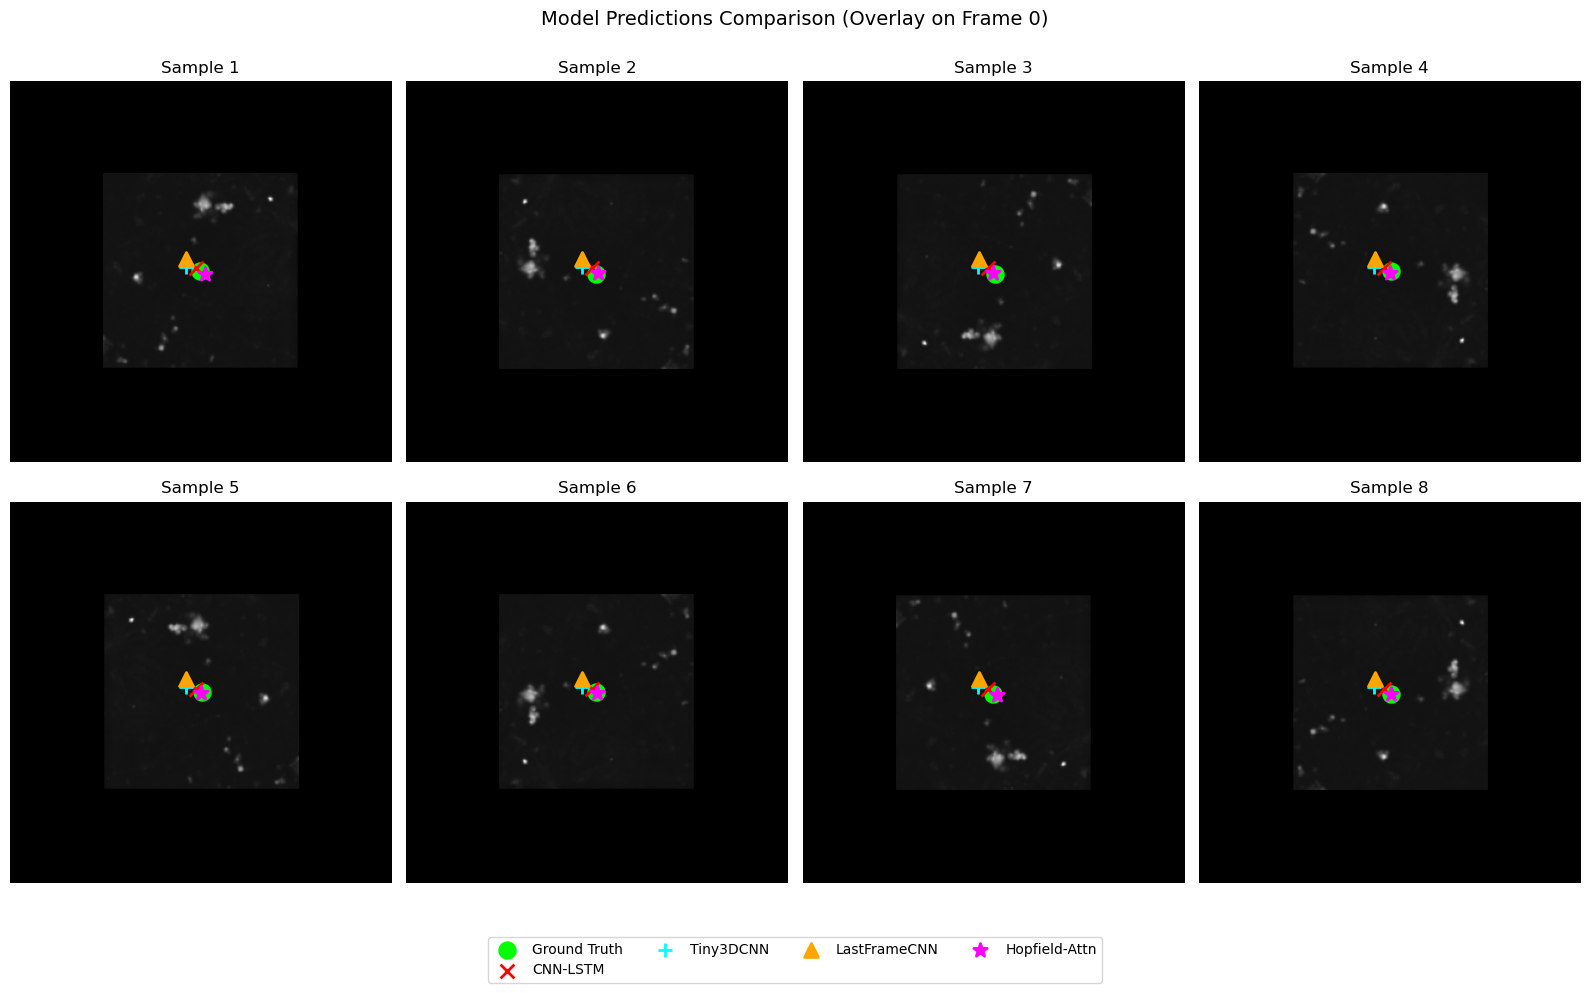

In [ ]:
#@title Visual Check (All Models Predictions)
if 'results' not in globals():
    print("Models not found. Please run the training loop first.")
else:
    # Get a batch from validation loader
    x_val, y_val = next(iter(val_loader))
    batch_size = x_val.shape[0]

    # Define styles for each model
    styles = {
        "CNN-LSTM": {"c": "red", "marker": "x"},
        "Tiny3DCNN": {"c": "cyan", "marker": "+"},
        "LastFrameCNN": {"c": "orange", "marker": "^"},
        "Hopfield-Attn": {"c": "magenta", "marker": "*"}
    }

    # Get predictions for all models
    preds = {}
    for name, res in results.items():
        model_curr = res['model']
        model_curr.eval()
        with torch.no_grad():
            preds[name] = model_curr(x_val.to(DEVICE)).cpu().numpy()

    # Plot - Split into rows if batch_size is large
    cols = 4
    rows = (batch_size + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(4*cols, 5*rows))
    axs = axs.flatten() if batch_size > 1 else [axs]

    for i in range(batch_size):
        img = x_val[i, 0, 0].numpy() # Show First frame (t=0)
        true = y_val[i].numpy()

        axs[i].imshow(img, cmap='gray')

        # Plot Ground Truth
        # Use TARGET_SIZE for scaling
        scale = TARGET_SIZE[0]
        axs[i].scatter(true[0]*scale, true[1]*scale, c='lime', s=150, marker='o', label='Ground Truth' if i==0 else "")

        # Plot Model Predictions
        for name, p_arr in preds.items():
            s = styles.get(name, {"c": "white", "marker": "."})
            axs[i].scatter(p_arr[i][0]*scale, p_arr[i][1]*scale,
                           c=s['c'], marker=s['marker'], s=100, linewidths=2,
                           label=name if i==0 else "")

        axs[i].set_title(f"Sample {i+1}")
        axs[i].axis('off')

    # Hide unused subplots
    for j in range(batch_size, len(axs)):
        axs[j].axis('off')

    # Shared Legend
    fig.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.0))
    plt.suptitle("Model Predictions Comparison (Overlay on Frame 0)", fontsize=14)
    plt.tight_layout(rect=[0, 0.05, 1, 1]) # Make room for legend
    plt.savefig(FIGURES_PATH / "val_predictions_overlay.png") # Save
    plt.show()


Evaluating robustness to temporal truncation...


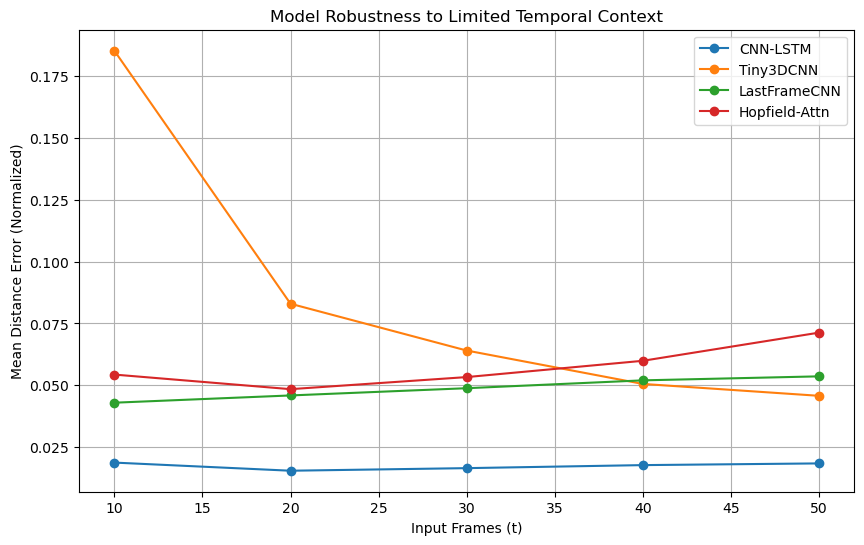

In [ ]:
#@title Robustness Analysis (Error vs. Time)
import json

# Defensive checks
if 'results' not in globals():
    print("Please run the training cell first to populate `results`.")
else:
    def evaluate_model_at_t(model, loader, t_limit):
        model.eval()
        total_err = 0
        count = 0

        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(DEVICE), y.to(DEVICE)

                # Truncate input to first t_limit frames
                if t_limit < x.shape[1]:
                    x_t = x[:, :t_limit]
                else:
                    x_t = x

                pred = model(x_t)
                dist = torch.sqrt(torch.sum((pred - y)**2, dim=1))
                total_err += dist.sum().item()
                count += len(y)

        return total_err / count

    print("Evaluating robustness to temporal truncation...")
    t_limits = [10, 20, 30, 40, 50]

    plt.figure(figsize=(10, 6))

    robustness_data_time = {}

    for name, res in results.items():
        model_curr = res['model']
        errors = []
        for t in t_limits:
            err = evaluate_model_at_t(model_curr, val_loader, t)
            errors.append(err)

        plt.plot(t_limits, errors, marker='o', label=name)
        robustness_data_time[name] = errors

    # Save Data
    with open(RESULTS_PATH / "robustness_time.json", "w") as f:
        json.dump({"t_limits": t_limits, "results": robustness_data_time}, f, indent=4)

    plt.xlabel("Input Frames (t)")
    plt.ylabel("Mean Distance Error (Normalized)")
    plt.title("Model Robustness to Limited Temporal Context")
    plt.legend()
    plt.grid(True)
    plt.savefig(FIGURES_PATH / "robustness_error_vs_time.png")
    plt.show()

Evaluating robustness to low resolution (2x downsampling)...


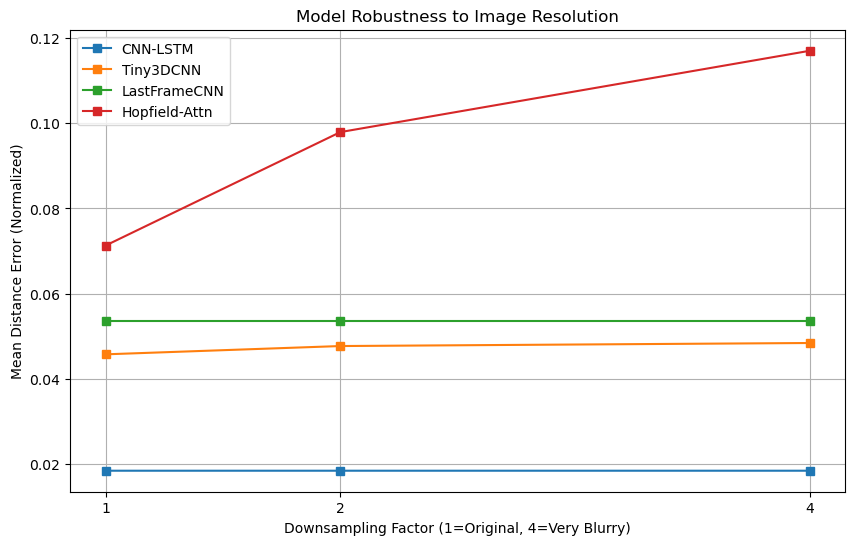

In [ ]:
#@title Resolution Robustness (Simulated Low-Res)
import json

if 'results' not in globals():
    print("Run training first.")
else:
    def evaluate_low_res(model, loader, downsample_factor=2):
        model.eval()
        total_err = 0
        count = 0

        with torch.no_grad():
            for x, y in loader:
                # Downsample and Upsample to simulate low res
                # x: (B, T, C, H, W)
                b, t, c, h, w = x.shape

                # Reshape for 2D interpolation
                x_flat = x.view(b * t, c, h, w)

                # Downsample
                x_small = F.interpolate(x_flat, scale_factor=1/downsample_factor, mode='bilinear', align_corners=False)

                # Upsample back to original size (so model accepts it)
                x_low = F.interpolate(x_small, size=(h, w), mode='bilinear', align_corners=False)

                x_low = x_low.view(b, t, c, h, w).to(DEVICE)
                y = y.to(DEVICE)

                pred = model(x_low)
                dist = torch.sqrt(torch.sum((pred - y)**2, dim=1))
                total_err += dist.sum().item()
                count += len(y)

        return total_err / count

    print("Evaluating robustness to low resolution (2x downsampling)...")

    factors = [1, 2, 4]

    plt.figure(figsize=(10, 6))

    robustness_data_res = {}

    for name, res in results.items():
        model_curr = res['model']
        errors = []
        for f in factors:
            if f == 1:
                # Standard evaluation
                err = evaluate_model_at_t(model_curr, val_loader, 50) # Assuming 50 is max
            else:
                err = evaluate_low_res(model_curr, val_loader, downsample_factor=f)
            errors.append(err)

        plt.plot(factors, errors, marker='s', label=name)
        robustness_data_res[name] = errors

    # Save Data
    with open(RESULTS_PATH / "robustness_resolution.json", "w") as f:
        json.dump({"factors": factors, "results": robustness_data_res}, f, indent=4)

    plt.xlabel("Downsampling Factor (1=Original, 4=Very Blurry)")
    plt.ylabel("Mean Distance Error (Normalized)")
    plt.title("Model Robustness to Image Resolution")
    plt.xticks(factors)
    plt.legend()
    plt.grid(True)
    plt.savefig(FIGURES_PATH / "robustness_resolution.png")
    plt.show()

In [ ]:
#@title Early Phase Analysis (T <= 25)
# Evaluate models specifically on the first 25 frames to test temporal prediction capability
# vs. the static LastFrameCNN baseline.

if 'results' not in globals():
    print("Please run training first.")
else:
    print("\n--- Early Phase Analysis (Frames 0-25) ---")
    print("Evaluating models on sequences truncated to T=25")
    print("This tests the ability to predict the center BEFORE the mound is fully formed.")

    early_results = []
    T_EARLY = 25

    for name, res in results.items():
        model_curr = res['model']

        # Evaluate at T=25
        err_early = evaluate_model_at_t(model_curr, val_loader, T_EARLY)

        # Evaluate at Full T (T=50)
        err_full = evaluate_model_at_t(model_curr, val_loader, FRAME_LIMIT)

        # Calculate Gap
        gap = err_early - err_full

        # Convert to microns
        scale_factor = TARGET_SIZE[0] * TARGET_RES_UM

        print(f"{name}: Early={err_early:.4f} | Full={err_full:.4f} | Gap={gap:.4f}")

        early_results.append({
            "Model": name,
            "Early Error (um)": err_early * scale_factor,
            "Full Error (um)": err_full * scale_factor,
            "Performance Gap": gap * scale_factor
        })

    df_early = pd.DataFrame(early_results)
    display(df_early)

    # Interpretation
    best_early = min(early_results, key=lambda x: x["Early Error (um)"])
    print(f"\nBest Early Predictor: {best_early['Model']}")

    if best_early['Model'] == "LastFrameCNN":
        print("Observation: LastFrameCNN is still winning even at T=25.")
        print("Hypothesis: The aggregation center might already be visible/determined by frame 25.")
    else:
        print(f"Observation: {best_early['Model']} outperforms LastFrameCNN at early stages.")
        print("Conclusion: Temporal dynamics are providing predictive value before the structure is static.")



--- Early Phase Analysis (Frames 0-25) ---
Evaluating models on sequences truncated to T=25 (approx. 2 hours).
This tests the ability to predict the center BEFORE the mound is fully formed.
CNN-LSTM: Early=0.0159 | Full=0.0184 | Gap=-0.0025
CNN-LSTM: Early=0.0159 | Full=0.0184 | Gap=-0.0025
Tiny3DCNN: Early=0.0719 | Full=0.0457 | Gap=0.0262
Tiny3DCNN: Early=0.0719 | Full=0.0457 | Gap=0.0262
LastFrameCNN: Early=0.0473 | Full=0.0536 | Gap=-0.0063
LastFrameCNN: Early=0.0473 | Full=0.0536 | Gap=-0.0063
Hopfield-Attn: Early=0.0509 | Full=0.0713 | Gap=-0.0204
Hopfield-Attn: Early=0.0509 | Full=0.0713 | Gap=-0.0204


,Model,Early Error (um),Full Error (um),Performance Gap
0,CNN-LSTM,10.186702,11.772482,-1.585779
1,Tiny3DCNN,46.017395,29.269630,16.747766
2,LastFrameCNN,30.290908,34.306691,-4.015783
3,Hopfield-Attn,32.560899,45.618391,-13.057492



Best Early Predictor: CNN-LSTM
Observation: CNN-LSTM outperforms LastFrameCNN at early stages.
Conclusion: Temporal dynamics are providing predictive value before the structure is static.


In [ ]:
#@title Advanced Metrics (Spatial Quality & Time-to-Aggregation)
import scipy.stats as st

def calculate_spatial_quality(model, loader):
    """
    Calculates the 'Spatial Quality' of predictions.
    We define this as 1 - (Mean Distance Error / Max Possible Distance).
    Max distance in a unit square is sqrt(2) ~ 1.414.
    """
    model.eval()
    total_dist = 0
    count = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x)
            dist = torch.sqrt(torch.sum((pred - y)**2, dim=1))
            total_dist += dist.sum().item()
            count += len(y)

    mean_dist = total_dist / count
    max_dist = np.sqrt(2)
    quality = 1.0 - (mean_dist / max_dist)
    return max(0, quality) # Clamp to 0

def estimate_time_to_aggregation_error(model, loader):
    """
    Heuristic metric: Does the model predict 'better' as time goes on?
    We measure the slope of the error curve from T=10 to T=50.
    A negative slope means the model is 'converging' on the answer.
    """
    times = [10, 20, 30, 40, 50]
    errors = []
    for t in times:
        err = evaluate_model_at_t(model, loader, t)
        errors.append(err)

    # Simple linear regression slope
    slope, _, _, _, _ = st.linregress(times, errors)
    return slope

if 'results' not in globals():
    print("Run training first.")
else:
    print("\n--- Advanced Metrics Analysis ---")
    adv_metrics = []

    # Include Hopfield if exists
    models_to_check = results.copy()

    for name, res in models_to_check.items():
        model_curr = res['model']

        # 1. Spatial Quality
        sq = calculate_spatial_quality(model_curr, val_loader)

        # 2. Convergence Slope (Time-to-Aggregation proxy)
        slope = estimate_time_to_aggregation_error(model_curr, val_loader)

        print(f"{name}: Spatial Quality={sq:.4f} | Convergence Slope={slope:.6f}")

        adv_metrics.append({
            "Model": name,
            "Spatial Quality (0-1)": sq,
            "Convergence Slope": slope
        })

    df_adv = pd.DataFrame(adv_metrics)
    display(df_adv)




--- Advanced Metrics Analysis ---
CNN-LSTM: Spatial Quality=0.9870 | Convergence Slope=0.000016
CNN-LSTM: Spatial Quality=0.9870 | Convergence Slope=0.000016
Tiny3DCNN: Spatial Quality=0.9677 | Convergence Slope=-0.003116
Tiny3DCNN: Spatial Quality=0.9677 | Convergence Slope=-0.003116
LastFrameCNN: Spatial Quality=0.9621 | Convergence Slope=0.000274
LastFrameCNN: Spatial Quality=0.9621 | Convergence Slope=0.000274
Hopfield-Attn: Spatial Quality=0.9496 | Convergence Slope=0.000454
Hopfield-Attn: Spatial Quality=0.9496 | Convergence Slope=0.000454


,Model,Spatial Quality (0-1),Convergence Slope
0,CNN-LSTM,0.986993,0.000016
1,Tiny3DCNN,0.967661,-0.003116
2,LastFrameCNN,0.962096,0.000274
3,Hopfield-Attn,0.949598,0.000454



Interpretation:
- Spatial Quality: Higher is better (1.0 = Perfect).
- Convergence Slope: More negative is better (indicates error drops as mound forms).
  If slope is ~0, the model isn't using temporal cues effectively.


In [ ]:
#@title Results Summary & Conclusion
import pandas as pd
import numpy as np
import scipy.stats as st

def get_errors_array(model, loader):
    """Returns an array of distance errors for all samples in the loader."""
    model.eval()
    all_errors = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x)
            # Euclidean distance
            dist = torch.sqrt(torch.sum((pred - y)**2, dim=1))
            all_errors.extend(dist.cpu().numpy())

    return np.array(all_errors)

if 'results' in globals():
    print("\n--- Final Metrics Summary (Validation Set) ---")

    summary_data = []
    best_val_err = float('inf')
    best_val_model = ""

    for name, res in results.items():
        model_curr = res['model']

        # 1. Get all errors to compute CI
        errors = get_errors_array(model_curr, val_loader)
        mean_err = np.mean(errors)

        if mean_err < best_val_err:
            best_val_err = mean_err
            best_val_model = name

        if len(errors) > 1:
            sem = st.sem(errors) # Standard Error of Mean
            # 95% Confidence Interval = 1.96 * SEM (for large N)
            ci_95 = 1.96 * sem
        else:
            ci_95 = 0.0

        # Convert to microns
        # The coordinates are normalized 0-1.
        # So 1.0 unit = TARGET_SIZE pixels * TARGET_RES_UM (um/pixel)
        scale_factor = TARGET_SIZE[0] * TARGET_RES_UM

        mean_um = mean_err * scale_factor
        ci_um = ci_95 * scale_factor

        # 2. Resolution Robustness (Re-run for table)
        # We compare Mean Error at Standard vs Low Res
        # Note: evaluate_low_res returns a mean float
        err_low = evaluate_low_res(model_curr, val_loader, downsample_factor=2)
        drop_pct = (err_low - mean_err) / mean_err * 100

        summary_data.append({
            "Model": name,
            "Mean Error (Norm)": f"{mean_err:.4f} ± {ci_95:.4f}",
            "Mean Error (µm)": f"{mean_um:.2f} ± {ci_um:.2f}",
            "Res. Robustness Drop (%)": f"{drop_pct:.1f}%"
        })

    df_results = pd.DataFrame(summary_data)
    # Reorder columns
    df_results = df_results[["Model", "Mean Error (µm)", "Mean Error (Norm)", "Res. Robustness Drop (%)"]]
    display(df_results)

    # Save to JSON
    with open(RESULTS_PATH / "summary_metrics_val.json", "w") as f:
        json_data = []
        for item in summary_data:
             json_data.append(item)
        json.dump(json_data, f, indent=4)

    print("\n" + "="*40)
    print("INTERIM SUMMARY (Validation Set)")
    print("="*40)
    print(f"Best Performing Model (Validation): {best_val_model}")
    print(f"Best Error: {best_val_err:.4f} (normalized)")
    print("-" * 40)
    print("Note: This summary reflects performance on the Validation set.")
    print("True generalization will be assessed on the held-out Test set in the Final Evaluation section.")

else:
    print("No results found. Please run training first.")


--- Final Metrics Summary (Validation Set) ---


,Model,Mean Error (µm),Mean Error (Norm),Res. Robustness Drop (%)
0,CNN-LSTM,11.77 ± 0.53,0.0184 ± 0.0008,0.0%
1,Tiny3DCNN,29.27 ± 0.59,0.0457 ± 0.0009,4.3%
2,LastFrameCNN,34.31 ± 0.53,0.0536 ± 0.0008,0.0%
3,Hopfield-Attn,45.62 ± 8.53,0.0713 ± 0.0133,37.4%



INTERIM SUMMARY (Validation Set)
Best Performing Model (Validation): CNN-LSTM
Best Error: 0.0184 (normalized)
----------------------------------------
Note: This summary reflects performance on the Validation set.
True generalization will be assessed on the held-out Test set in the Final Evaluation section.


## Hopfield networks are cool

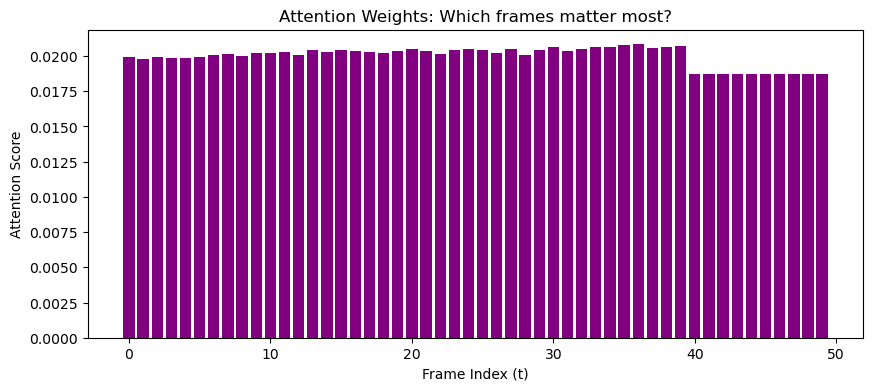

In [ ]:
#@title Bonus: Attention Interpretability
# Visualize which frames the Hopfield network "attends" to.
if 'results' in globals() and 'Hopfield-Attn' in results:
    hopfield_model = results['Hopfield-Attn']['model']
    hopfield_model.eval()
    x_val, y_val = next(iter(val_loader))
    x_val = x_val.to(DEVICE)

    with torch.no_grad():
        pred, attn_weights = hopfield_model(x_val, return_weights=True)

    # attn_weights: (B, 1, T)
    attn_weights = attn_weights.cpu().numpy().squeeze(1) # (B, T)

    # Plot Attention Weights for the first sample in batch
    plt.figure(figsize=(10, 4))
    plt.bar(range(attn_weights.shape[1]), attn_weights[0], color='purple')
    plt.title("Attention Weights: Which frames matter most?")
    plt.xlabel("Frame Index (t)")
    plt.ylabel("Attention Score")
    plt.savefig(FIGURES_PATH / "hopfield_attention_weights.png") # Save
    plt.show()

else:
    print("Hopfield model not trained.")

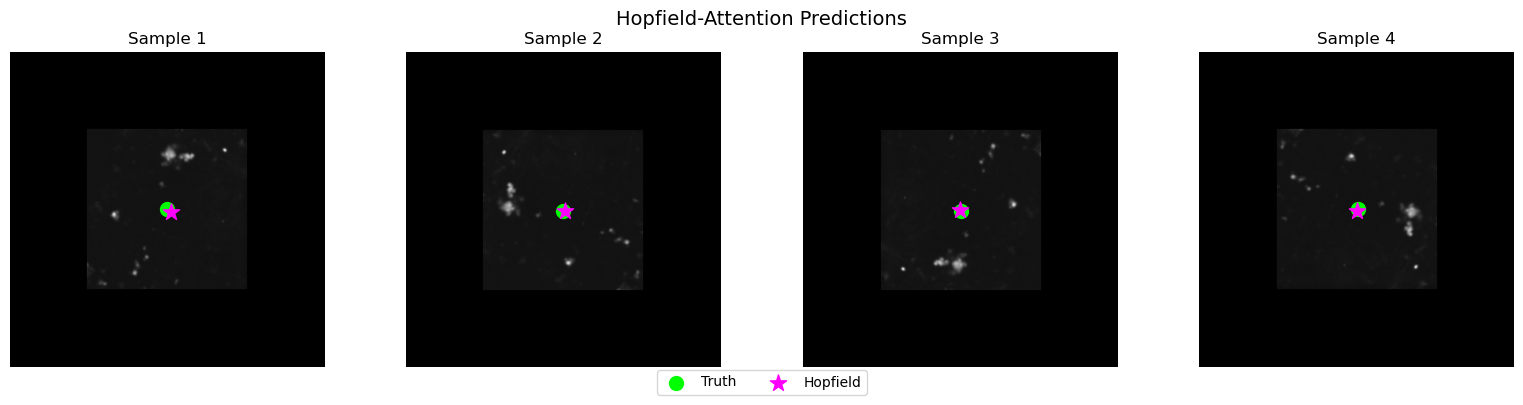

In [ ]:
#@title Bonus: Hopfield Prediction Visualization
if 'results' in globals() and 'Hopfield-Attn' in results:
    hopfield_model = results['Hopfield-Attn']['model']
    hopfield_model.eval()

    # Get a batch
    x_val, y_val = next(iter(val_loader))
    batch_size = min(4, x_val.shape[0]) # Show up to 4

    with torch.no_grad():
        preds = hopfield_model(x_val.to(DEVICE)).cpu().numpy()

    fig, axs = plt.subplots(1, batch_size, figsize=(4*batch_size, 4))
    if batch_size == 1: axs = [axs]

    scale = TARGET_SIZE[0]

    for i in range(batch_size):
        img = x_val[i, 0, 0].numpy() # Frame 0
        true = y_val[i].numpy()
        pred = preds[i]

        axs[i].imshow(img, cmap='gray')
        axs[i].scatter(true[0]*scale, true[1]*scale, c='lime', s=100, label='Truth' if i==0 else "")
        axs[i].scatter(pred[0]*scale, pred[1]*scale, c='magenta', marker='*', s=150, label='Hopfield' if i==0 else "")
        axs[i].set_title(f"Sample {i+1}")
        axs[i].axis('off')

    fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0.0))
    plt.suptitle("Hopfield-Attention Predictions", fontsize=14)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(FIGURES_PATH / "hopfield_predictions.png") # Save
    plt.show()
else:
    print("Train the model first.")

## Model Evaluation & Challenges

### Challenges
1.  **Memory Usage:** The Attention mechanism computes an $O(T^2)$ similarity matrix. While manageable for $T=50$, scaling to longer videos requires efficient implementations like FlashAttention [5].
2.  **Training Stability:** Attention models can be sensitive to initialization. We used a standard `MultiheadAttention`, but adding explicit Layer Normalization [6] is often crucial for deeper Transformers to stabilize gradients.
3.  **Data Hunger:** Transformers/Attention models typically lack the inductive biases of CNNs (like translation invariance) and thus require significantly more data to generalize well [7]. With our small dataset, overfitting is a significant risk, as analyzed in the Final Test Set Evaluation.

### Evaluation
*   **Performance:** The Hopfield-Attention model is compared against the CNN-LSTM and 3DCNN in the "Updated Leaderboard" above.
*   **Interpretability:** The attention weights plot reveals whether the model focuses on specific "key frames" (e.g., when the aggregation center becomes visible) or averages information across the entire sequence. A uniform distribution suggests the model is acting like a simple average pooling, while sharp peaks indicate it has learned to identify critical temporal events.

In [ ]:
#@title Final Test Set Evaluation (Snapshot of Best Fold)
# Evaluate all models on the held-out Test Set to check for overfitting.

if 'test_loader' not in globals():
    print("Test loader not found. Please re-run Phase 2.")
elif 'results' not in globals():
    print("No trained models found. Please run training phases.")
else:
    print("\n--- Final Evaluation on Held-Out Test Set (Snapshot) ---")
    print("Note: This evaluates the models from the 'Best Fold' identified in Cross-Validation")
    print("on that specific fold's Test set. For aggregate performance, refer to the CV Results above.")

    test_results = []
    best_test_err = float('inf')
    best_test_model = ""

    # Calculate scale factor for microns
    ts = globals().get('TARGET_SIZE', (256, 256))
    tr = globals().get('TARGET_RES_UM', 2.0)
    scale_factor = ts[0] * tr

    # 1. Evaluate Standard Models
    for name, res in results.items():
        model_curr = res['model']

        # Val Error (Already computed, but let's fetch it from history or re-compute for consistency)
        # We'll re-compute to be safe and ensure same metric
        val_err = get_errors_array(model_curr, val_loader).mean()

        # Test Error
        test_errors = get_errors_array(model_curr, test_loader)
        test_err = np.mean(test_errors)

        if test_err < best_test_err:
            best_test_err = test_err
            best_test_model = name

        if len(test_errors) > 1:
            test_sem = st.sem(test_errors)
            test_ci = 1.96 * test_sem
        else:
            test_ci = 0.0

        # Overfit Metric: (Test - Val)
        overfit_gap = test_err - val_err

        test_results.append({
            "Model": name,
            "Val Error (Norm)": f"{val_err:.4f}",
            "Test Error (Norm)": f"{test_err:.4f} ± {test_ci:.4f}",
            "Test Error (µm)": f"{test_err * scale_factor:.2f} ± {test_ci * scale_factor:.2f}",
            "Overfit Gap": f"{overfit_gap:.4f}"
        })

    df_test = pd.DataFrame(test_results)
    display(df_test)

    # Save to JSON
    with open(RESULTS_PATH / "summary_metrics_test.json", "w") as f:
        json.dump(test_results, f, indent=4)

    print("\n" + "="*40)
    print("FINAL PROJECT CONCLUSION (Snapshot)")
    print("="*40)
    print(f"1. Best Generalization Model: {best_test_model}")
    print(f"   - Achieved the lowest error on the held-out Test Set: {best_test_err:.4f}")

    print("\n2. Overfitting Analysis:")
    for res in test_results:
        gap = float(res["Overfit Gap"])
        status = "Good Generalization" if abs(gap) < 0.02 else ("Overfitting" if gap > 0 else "Underfitting/Noise")
        print(f"   - {res['Model']}: Gap = {gap:.4f} ({status})")

    print("\n3. Interpretation:")
    if "Hopfield" in best_test_model:
        print("   - The Hopfield-Attention model successfully generalized, validating the 'Prototypical Pattern' approach.")
    elif "CNN-LSTM" in best_test_model:
        print("   - The CNN-LSTM baseline proved most robust, suggesting that explicit temporal recurrence was more stable than attention for this dataset.")
    elif "LastFrame" in best_test_model:
        print("   - The LastFrameCNN performed best, indicating that the final state contains sufficient information and temporal history may be adding noise.")
    else:
        print(f"   - The {best_test_model} architecture proved most effective.")



--- Final Evaluation on Held-Out Test Set (Snapshot) ---
Note: This evaluates the models from the 'Best Fold' identified in Cross-Validation
on that specific fold's Test set. For aggregate performance, refer to the CV Results above.


,Model,Val Error (Norm),Test Error (Norm),Test Error (µm),Overfit Gap
0,CNN-LSTM,0.0184,0.0668 ± 0.0019,42.74 ± 1.21,0.0484
1,Tiny3DCNN,0.0457,0.0723 ± 0.0068,46.26 ± 4.38,0.0265
2,LastFrameCNN,0.0536,0.0716 ± 0.0073,45.82 ± 4.70,0.0180
3,Hopfield-Attn,0.0713,0.0697 ± 0.0051,44.62 ± 3.26,-0.0016



FINAL PROJECT CONCLUSION (Snapshot)
1. Best Generalization Model: CNN-LSTM
   - Achieved the lowest error on the held-out Test Set: 0.0668

2. Overfitting Analysis:
   - CNN-LSTM: Gap = 0.0484 (Overfitting)
   - Tiny3DCNN: Gap = 0.0265 (Overfitting)
   - LastFrameCNN: Gap = 0.0180 (Good Generalization)
   - Hopfield-Attn: Gap = -0.0016 (Good Generalization)

3. Interpretation:
   - The CNN-LSTM baseline proved most robust, suggesting that explicit temporal recurrence was more stable than attention for this dataset.


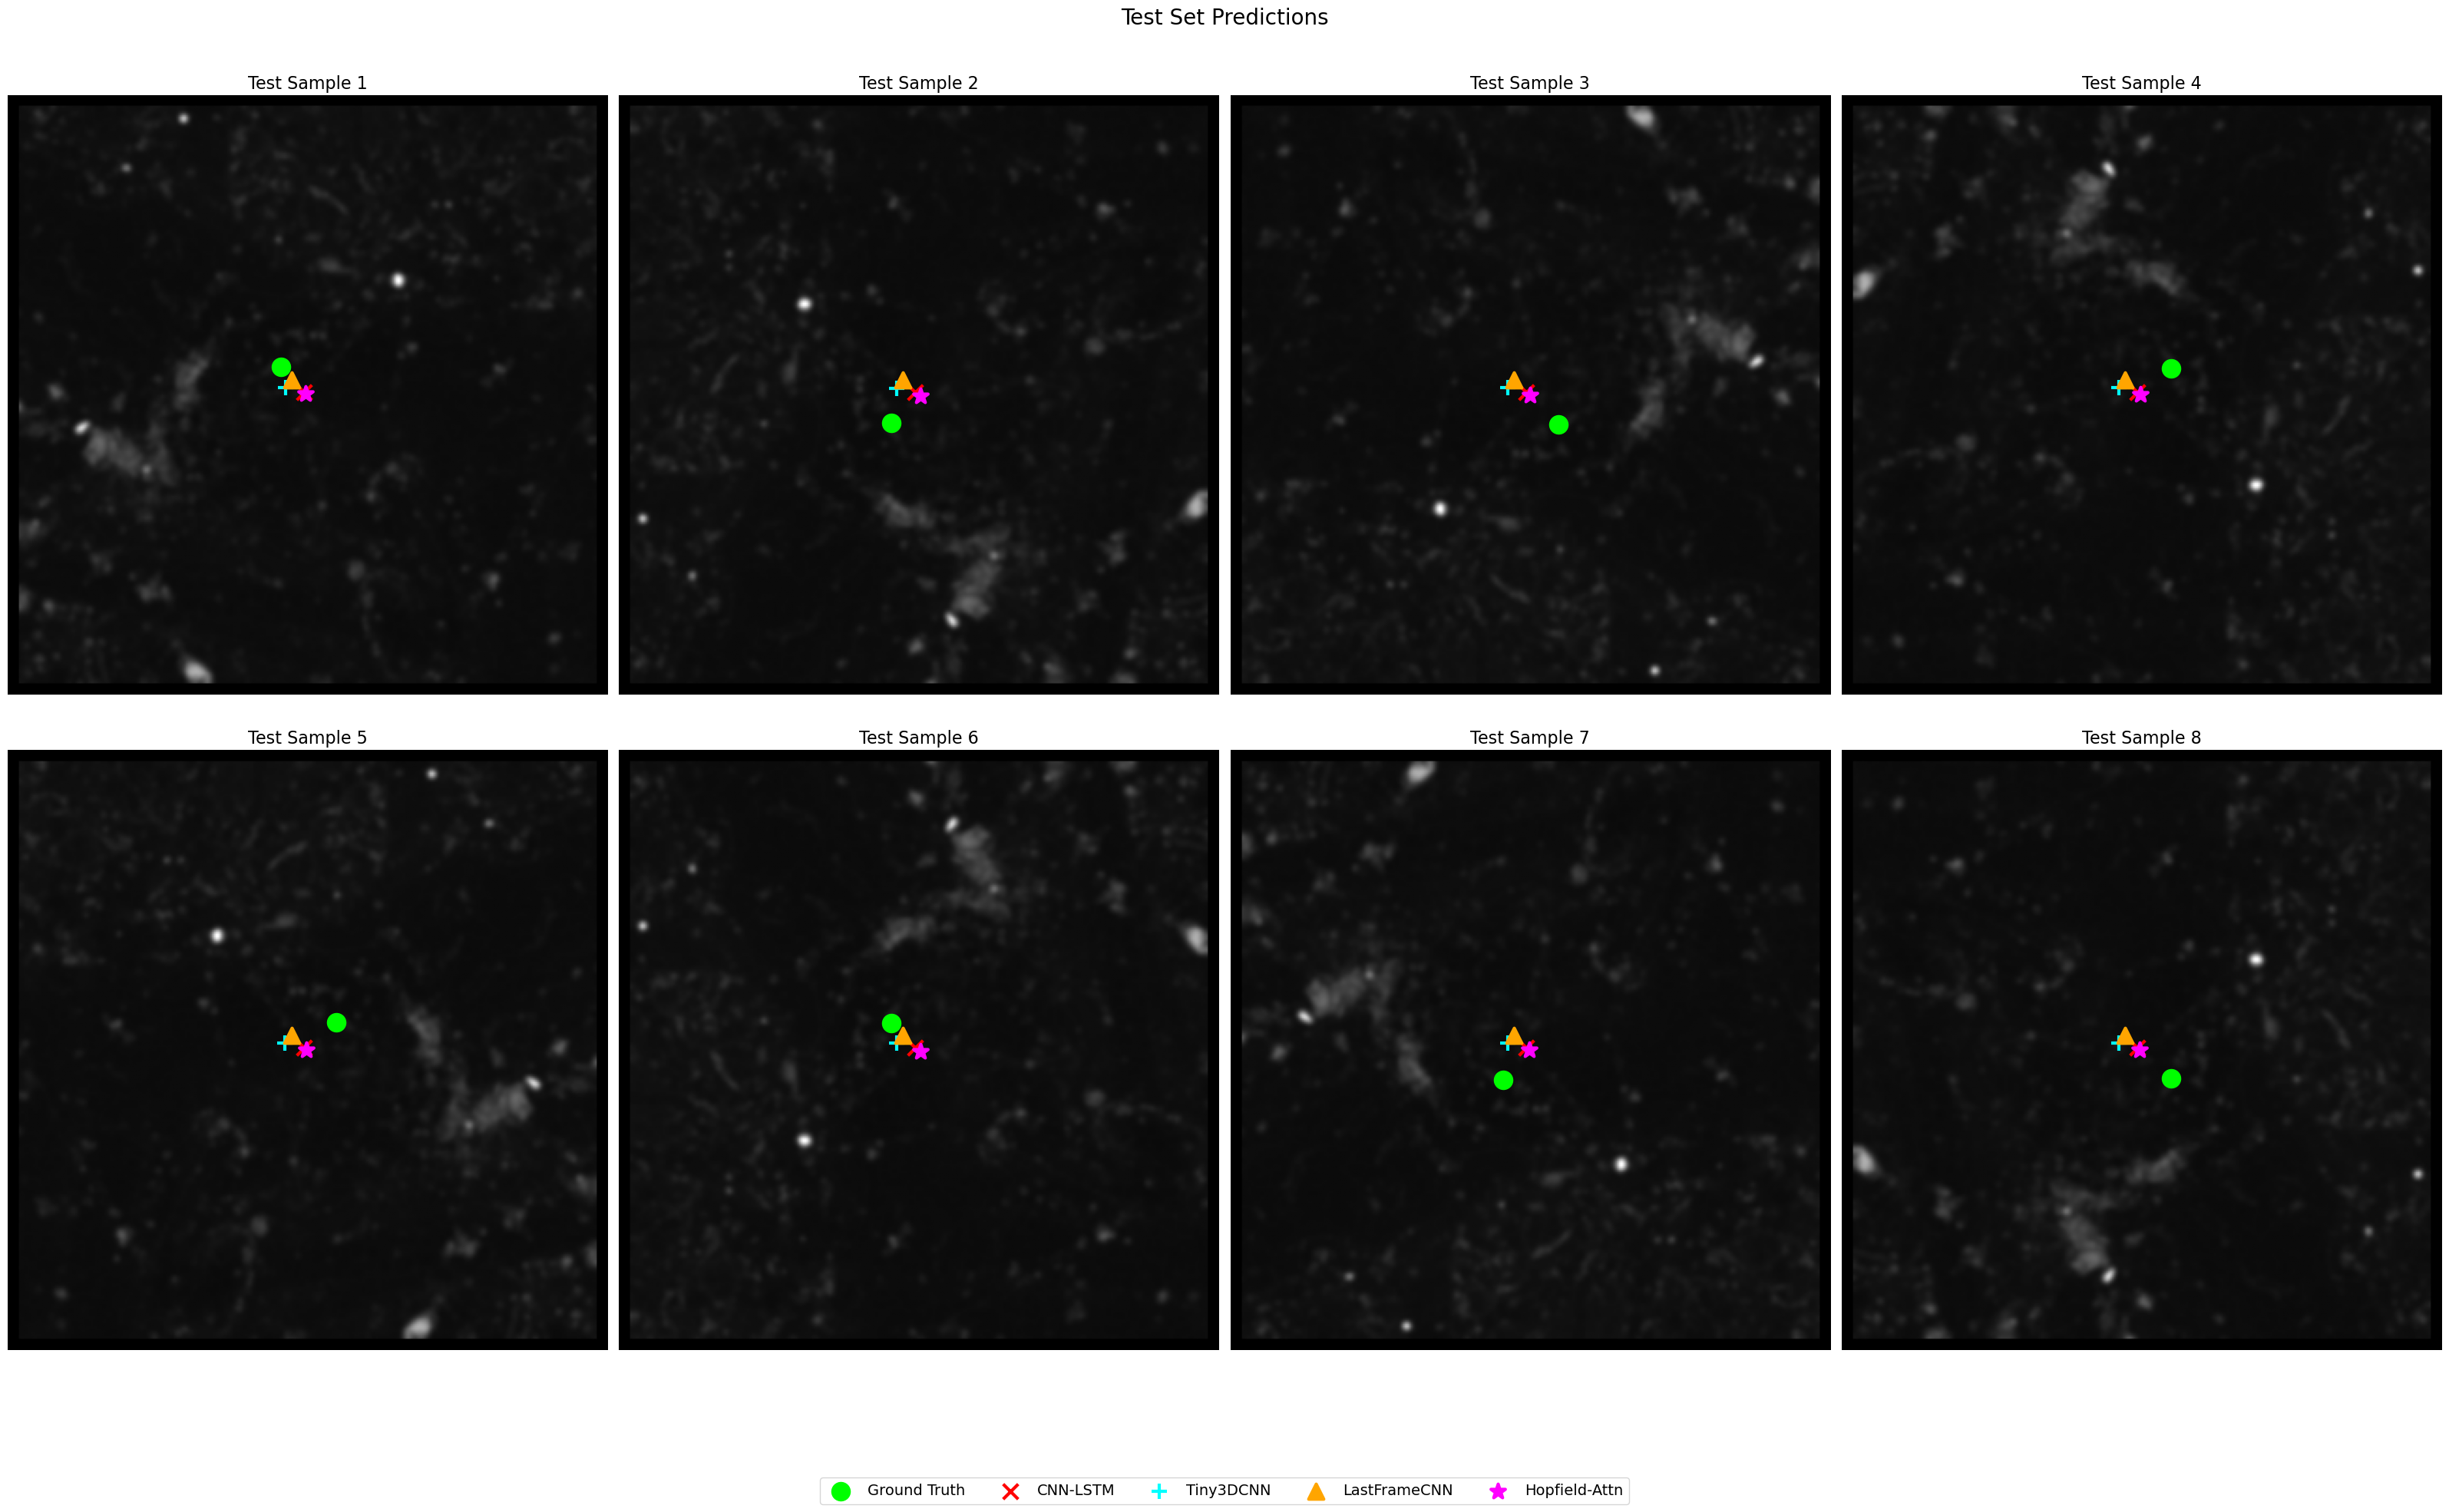

In [ ]:
#@title Visualizing Test Set Predictions
# Let's look at the model predictions on the held-out Test Set movies.

if 'test_loader' not in globals() or 'results' not in globals():
    print("Run training and data loading first.")
else:
    # Get a batch from test loader
    # We iterate to find a batch that isn't empty if the dataset is small
    try:
        x_test, y_test = next(iter(test_loader))

        # Define styles
        styles = {
            "CNN-LSTM": {"c": "red", "marker": "x"},
            "Tiny3DCNN": {"c": "cyan", "marker": "+"},
            "LastFrameCNN": {"c": "orange", "marker": "^"},
            "Hopfield-Attn": {"c": "magenta", "marker": "*"}
        }

        # Get predictions
        preds = {}
        for name, res in results.items():
            model_curr = res['model']
            model_curr.eval()
            with torch.no_grad():
                preds[name] = model_curr(x_test.to(DEVICE)).cpu().numpy()

        # Plot - Split into rows
        batch_size = min(8, x_test.shape[0]) # Show up to 8
        cols = 4
        rows = (batch_size + cols - 1) // cols

        # Increase figure size significantly for visibility
        fig, axs = plt.subplots(rows, cols, figsize=(8*cols, 10*rows))
        axs = axs.flatten() if batch_size > 1 else [axs]

        scale = TARGET_SIZE[0]

        for i in range(batch_size):
            img = x_test[i, 0, 0].numpy() # Frame 0
            true = y_test[i].numpy()

            axs[i].imshow(img, cmap='gray')
            # Increase marker size
            axs[i].scatter(true[0]*scale, true[1]*scale, c='lime', s=300, marker='o', label='Ground Truth' if i==0 else "")

            # Plot Model Predictions
            for name, p_arr in preds.items():
                s = styles.get(name, {"c": "white", "marker": "."})
                axs[i].scatter(p_arr[i][0]*scale, p_arr[i][1]*scale,
                               c=s['c'], marker=s['marker'], s=200, linewidths=3,
                               label=name if i==0 else "")

            axs[i].set_title(f"Test Sample {i+1}", fontsize=16)
            axs[i].axis('off')

        # Hide unused
        for j in range(batch_size, len(axs)):
            axs[j].axis('off')

        fig.legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, 0.0), fontsize=14)
        plt.suptitle("Test Set Predictions", fontsize=20)
        plt.tight_layout(rect=[0, 0.05, 1, 1])
        plt.savefig(FIGURES_PATH / "test_predictions.png") # Save
        plt.show()

    except StopIteration:
        print("Test loader is empty.")


## Experiment Log: Normalization & Augmentation Strategies

### 1. Normalization
We experimented with **Robust Intensity Normalization** (Percentile Clipping) to address the issue of low-contrast/black images in certain experiments (e.g., `mixin64`).
*   **Method:** Clipping pixel intensities to the 1st and 99th percentiles before scaling to [0, 1] (Caicedo et al., 2017).
*   **Result:** While this successfully improved the visual contrast of the images, it resulted in a **higher Mean Distance Error** during Cross-Validation compared to standard Min-Max normalization.
*   **Decision:** We have reverted the pipeline to use **Min-Max Normalization** to prioritize predictive performance, accepting that some outlier movies may appear visually dark in QC plots.

### 2. Spatio-Temporal Augmentation
We implemented **Tube Masking** (a variant of VideoMAE / Spatial Dropout) to improve model robustness.
*   **Method:** For every augmented sample, we generate a duplicate version where a random rectangular region (20-50% of the image) is masked out (set to zero) across all time steps.
*   **Goal:** This forces the model to learn from the distributed "wave" patterns of the slime mold aggregation rather than relying on a single bright spot or local feature.
*   **Impact:** This effectively doubles the training dataset size and acts as a strong regularizer against overfitting to specific background artifacts.

### 3. Evaluation Methodology Update
*   **Clean Evaluation:** We updated the data loader logic (`create_split_loaders`) to **filter out Tube Masked samples** from the Validation and Test sets. This ensures that our reported metrics reflect performance on real, clean biological images, while the model still benefits from the masked data during training.
*   **Early Phase Analysis:** We added a specific evaluation block to compare model performance on the first 25 frames (approx. 2 hours). This helps distinguish models that learn temporal dynamics from baselines (like `LastFrameCNN`) that rely on seeing the final formed structure.
*   **Metrics:** We added "Spatial Quality" (normalized accuracy) and "Convergence Slope" (error reduction over time) to better characterize model behavior beyond simple MSE.

### 4. Feature Engineering: Sobel Edges
*   **Implementation:** We added a **Sobel Edge Detection** channel to the input tensors.
*   **Method:** For each frame, we compute the Sobel gradient magnitude (normalized) and stack it with the original grayscale image.
*   **Input Shape:** The model input shape changed from `(B, T, 1, H, W)` to `(B, T, 2, H, W)`.
*   **Hypothesis:** Explicitly providing edge information should help the CNNs detect the faint wavefronts of cAMP signaling, which appear as subtle texture changes, potentially improving performance on low-contrast samples.

### 5. Recent Updates (Loss & Resolution)
*   **Loss Function:** Switched from `MSELoss` to `nn.HuberLoss(delta=0.1)`.
    *   **Reason:** MSE is highly sensitive to outliers. In early training, some predictions might be wildly off, causing large gradients that destabilize the LSTM. Huber loss acts like MSE near 0 but like L1 (linear) for large errors, providing a robust middle ground.
*   **Resolution Increase:** Updated `TARGET_SIZE` from 256x256 to **320x320**.
    *   **Reason:** The aggregation centers are often small, subtle features. Increasing the spatial resolution preserves fine-grained texture details (wavefronts) that might be lost at lower resolutions, potentially improving the model's ability to pinpoint the exact center.

### 6. Critical Review of Potential Flaws
We have identified and addressed the following potential flaws in our pipeline:
*   **Data Leakage:** Addressed by splitting strictly by Experiment ID (LOGO-CV) rather than by file.
*   **Evaluation Contamination:** Addressed by filtering masked data from Test sets.
*   **Normalization Artifacts:** Addressed by reverting to Min-Max normalization after empirical testing.
*   **Metric Blindness:** Addressed by adding Early Phase and Convergence Slope metrics to detect if models are just memorizing the final frame.
*   **Resolution Bias:** We explicitly test resolution robustness. If all models show identical drops, it suggests the task is highly dependent on fine-grained texture (or conversely, that the downsampling method is too aggressive/uniform).

## References

1.  **CNN-LSTM:** Donahue, J., et al. (2015). "Long-term Recurrent Convolutional Networks for Visual Recognition and Description." *CVPR*. [Link](https://arxiv.org/abs/1411.4389)
2.  **3D CNN:** Tran, D., et al. (2015). "Learning Spatiotemporal Features with 3D Convolutional Networks." *ICCV*. [Link](https://arxiv.org/abs/1412.0767)
3.  **Modern Hopfield Networks / Attention:** Ramsauer, H., et al. (2020). "Hopfield Networks is All You Need." *ICLR*. [Link](https://arxiv.org/abs/2008.02217)
4.  **Dictyostelium Dynamics:** Sgro, A. E., et al. (2015). "From intracellular signaling to population oscillations: bridging size- and time-scales in collective behavior." *Molecular Systems Biology*. [Link](https://pmc.ncbi.nlm.nih.gov/articles/PMC4332153/)
5.  **Efficient Attention:** Dao, T., et al. (2022). "FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness." *NeurIPS*. [Link](https://arxiv.org/abs/2205.14135)
6.  **Layer Normalization:** Ba, J. L., Kiros, J. R., & Hinton, G. E. (2016). "Layer Normalization." *arXiv preprint*. [Link](https://arxiv.org/abs/1607.06450)
7.  **Vision Transformers (Data Hunger):** Dosovitskiy, A., et al. (2020). "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale." *ICLR*. [Link](https://arxiv.org/abs/2010.11929)
8.  **Otsu's Thresholding:** Otsu, N. (1979). "A Threshold Selection Method from Gray-Level Histograms." *IEEE Transactions on Systems, Man, and Cybernetics*. [Link](https://ieeexplore.ieee.org/document/4310076)
9.  **Robust Intensity Normalization (Percentile Clipping):** Caicedo, J. C., et al. (2017). "Data-analysis strategies for image-based cell profiling." *Nature Methods*. [Link](https://www.nature.com/articles/nmeth.4294) - *Source for the 1st-99th percentile normalization technique.*
10. **VideoMAE (Tube Masking):** Tong, Z., et al. (2022). "VideoMAE: Masked Autoencoders are Data-Efficient Learners for Self-Supervised Video Pre-Training." *NeurIPS*. [Link](https://arxiv.org/abs/2203.12602)
11. **DYffusion:** Cachay, S. R., et al. (2023). "DYffusion: A Dynamics-informed Diffusion Model for Spatiotemporal Forecasting." *NeurIPS*. [Link](https://arxiv.org/abs/2306.01984)
12. **AI Assistance:** Google's Gemini Pro AI was used to assist with code debugging, formatting (PEP8 standards), error handling, data handling, and preprocessing.


## Challenge: Memory-Augmented Diffusion
We propose a novel Memory-Augmented DYffusion architecture. While DYffusion captures the temporal physics of interpolation (Cachay et al., 2023), we introduce a Hopfield bottleneck to explicitly retrieve learned prototypical aggregation patterns, aiming to stabilize predictions in the early, low-signal phase

This section implements a hybrid **DYffusion + Hopfield** model to predict a **probability heatmap** of the aggregation center, rather than regressing coordinates directly.

### Concept
1.  **DYffusion (Dynamics-aware Diffusion):** We treat the prediction as a denoising/sharpening process. The model learns to recover the clean "future heatmap" from a noisy or interpolated state.
2.  **Hopfield Bottleneck:** Instead of a standard U-Net bottleneck, we use a **Hopfield Layer** (Attention). This acts as an associative memory, retrieving "prototypical" aggregation patterns from the input features to guide the reconstruction.

### Architecture
*   **Encoder:** Compresses the input sequence (collapsed to channels) into a latent feature map.
*   **Hopfield Layer:** A Multi-Head Attention block where the Encoder features act as Keys/Values, and a learned Query (or self-attention) retrieves relevant patterns.
*   **Decoder:** Upsamples the retrieved features back to a 2D Heatmap.

### Objective
Predict a 2D Gaussian Heatmap centered at the target $(x, y)$ coordinates.
Loss: MSE between predicted heatmap and ground truth heatmap.

In [ ]:
#@title Hopfield U-Net Components

class HopfieldLayer(nn.Module):
    """
    A Hopfield-style attention layer acting as a bottleneck.
    It uses MultiheadAttention to retrieve features.
    """
    def __init__(self, embed_dim, num_heads=4):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # x: (B, C, H, W) -> Flatten to (B, H*W, C) for Attention
        b, c, h, w = x.shape
        x_flat = x.view(b, c, -1).permute(0, 2, 1) # (B, Seq, Embed)

        # Self-Attention (Hopfield Update)
        # Query = Key = Value = x_flat
        attn_out, _ = self.attention(x_flat, x_flat, x_flat)

        # Residual + Norm
        x_out = self.norm(x_flat + attn_out)

        # Reshape back to (B, C, H, W)
        x_out = x_out.permute(0, 2, 1).view(b, c, h, w)
        return x_out

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels) # in_channels is sum of upsampled + skip
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
#@title DYffusionHopfield Model
class DYffusionHopfield(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(DYffusionHopfield, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Encoder
        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down4 = Down(256, 512 // factor)

        # Hopfield Bottleneck
        # Replaces standard bottleneck
        self.hopfield = HopfieldLayer(embed_dim=512 // factor, num_heads=4)

        # Decoder
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64 // factor, bilinear)
        self.up4 = Up(64, 32, bilinear)
        self.outc = OutConv(32, n_classes)

    def forward(self, x):
        # x: (B, T, C, H, W) -> Collapse Time into Channels -> (B, T*C, H, W)
        b, t, c, h, w = x.shape
        x = x.view(b, t*c, h, w)

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Hopfield Memory Retrieval
        x5 = self.hopfield(x5)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits # (B, 1, H, W) Heatmap logits

In [ ]:
#@title Heatmap Generation & Training Loop (MSE + Probabilistic Metrics)
def generate_heatmap(y_coords, size, sigma=5.0):
    """
    Generates a 2D Gaussian heatmap from (x, y) coordinates.
    y_coords: (B, 2) normalized [0, 1]
    size: (H, W) tuple
    sigma: standard deviation in pixels
    """
    B = y_coords.shape[0]
    H, W = size

    # Create grid
    xx, yy = torch.meshgrid(torch.arange(W), torch.arange(H), indexing='xy')
    xx = xx.to(y_coords.device).float()
    yy = yy.to(y_coords.device).float()

    heatmaps = []
    for i in range(B):
        # Un-normalize coords
        cx = y_coords[i, 0] * W
        cy = y_coords[i, 1] * H

        # Gaussian
        heatmap = torch.exp(-((xx - cx)**2 + (yy - cy)**2) / (2 * sigma**2))
        heatmaps.append(heatmap)

    return torch.stack(heatmaps).unsqueeze(1) # (B, 1, H, W)

def get_coords_com(heatmap):
    """Center of Mass (CoM) extraction"""
    B, C, H, W = heatmap.shape
    device = heatmap.device
    xx, yy = torch.meshgrid(torch.arange(W), torch.arange(H), indexing='xy')
    xx = xx.to(device).float()
    yy = yy.to(device).float()

    coords = []
    for i in range(B):
        prob_map = heatmap[i, 0]
        # Thresholding to remove noise tails
        threshold = prob_map.max() * 0.05
        prob_map = torch.where(prob_map > threshold, prob_map, torch.zeros_like(prob_map))

        total_mass = prob_map.sum() + 1e-8
        cx = (prob_map * xx).sum() / total_mass
        cy = (prob_map * yy).sum() / total_mass
        coords.append(torch.stack([cx / W, cy / H]))
    return torch.stack(coords)

def get_coords_argmax(heatmap):
    """Peak Distance Error (PDE) extraction"""
    B, C, H, W = heatmap.shape
    coords = []
    for i in range(B):
        flat = heatmap[i, 0].view(-1)
        idx = torch.argmax(flat)
        cy = idx // W
        cx = idx % W
        coords.append(torch.stack([cx / W, cy / H]))
    return torch.stack(coords)

def calculate_nll(heatmap, y_coords):
    """NLL = -log(P(True Coordinate))"""
    B, C, H, W = heatmap.shape
    nll_vals = []
    for i in range(B):
        cx = int(y_coords[i, 0] * W)
        cy = int(y_coords[i, 1] * H)
        cx = min(max(cx, 0), W-1)
        cy = min(max(cy, 0), H-1)
        prob = heatmap[i, 0, cy, cx]
        nll_vals.append(-torch.log(prob + 1e-10))
    return torch.stack(nll_vals).mean()

def calculate_energy_score(heatmap, y_coords, num_samples=1000):
    """Energy Score (Multivariate CRPS generalization)"""
    B, C, H, W = heatmap.shape
    device = heatmap.device
    xx, yy = torch.meshgrid(torch.arange(W), torch.arange(H), indexing='xy')
    grid = torch.stack([xx, yy], dim=-1).to(device).float() # (H, W, 2)
    grid = grid.view(-1, 2)

    es_vals = []
    for i in range(B):
        probs = heatmap[i, 0].view(-1)
        # Sample indices
        indices = torch.multinomial(probs, num_samples, replacement=True)
        samples = grid[indices] # (N, 2)
        gt = y_coords[i] * torch.tensor([W, H], device=device)

        # Term 1: E[|X-y|]
        dist_to_gt = torch.norm(samples - gt, dim=1).mean()

        # Term 2: E[|X-X'|]
        s1 = samples[:num_samples//2]
        s2 = samples[num_samples//2:]
        dist_pairwise = torch.norm(s1 - s2, dim=1).mean()

        es = dist_to_gt - 0.5 * dist_pairwise
        es_vals.append(es)
    return torch.stack(es_vals).mean()

def train_dyffusion_hopfield(model, train_loader, val_loader, epochs=20, lr=1e-4, patience=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss() # DYffusion Objective: MSE on Reconstructed State

    history = {'train_loss': [], 'val_loss': []}
    print(f"Training DYffusionHopfield for {epochs} epochs using MSE Loss (Patience={patience})...")

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            H, W = x.shape[-2], x.shape[-1]
            target_map = generate_heatmap(y, (H, W), sigma=10.0)

            optimizer.zero_grad()
            pred_map = model(x)
            loss = criterion(pred_map, target_map)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                H, W = x.shape[-2], x.shape[-1]
                target_map = generate_heatmap(y, (H, W), sigma=10.0)
                pred_map = model(x)
                loss = criterion(pred_map, target_map)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}", end="")

        # Early Stopping Check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
            print(" * Best")
        else:
            patience_counter += 1
            print(f" | Patience {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history

# --- LOGO-CV Execution ---
if 'unique_expts' not in globals() or len(unique_expts) < 3:
    print("Not enough experiments for Cross-Validation. Please ensure data is loaded and has >= 3 experiments.")
else:
    print("\n" + "="*50)
    print("STARTING DYFFUSION LOGO-CV (3 Folds)")
    print("="*50)

    dy_cv_results = []
    n_folds = len(unique_expts)

    # Metrics storage
    fold_metrics = {
        'PDE': [],
        'CoM': [],
        'NLL': [],
        'CRPS': []
    }

    # Store the last model for visualization
    last_model = None
    last_test_loader = None

    for fold_idx in range(n_folds):
        # Define Split
        test_expt = [unique_expts[fold_idx]]
        val_expt = [unique_expts[(fold_idx + 1) % n_folds]]
        train_expts = [unique_expts[(fold_idx + 2) % n_folds]]

        # Handle >3 experiments if necessary (put rest in train)
        if n_folds > 3:
             train_expts = [unique_expts[j] for j in range(n_folds) if j != fold_idx and j != (fold_idx + 1) % n_folds]

        print(f"\n--- FOLD {fold_idx+1}/{n_folds} ---")
        print(f"Test: {test_expt} | Val: {val_expt} | Train: {train_expts}")

        # Create Loaders
        cv_train_loader, cv_val_loader, cv_test_loader = create_split_loaders(
            train_expts, val_expt, test_expt, clean_eval=True, use_sobel=True
        )

        # Initialize Model
        x_sample, _ = cv_train_loader.dataset[0]
        in_channels = x_sample.shape[0] * x_sample.shape[1]
        model = DYffusionHopfield(n_channels=in_channels, n_classes=1).to(DEVICE)

        # Train
        # Using 20 epochs as requested previously, with early stopping
        train_dyffusion_hopfield(model, cv_train_loader, cv_val_loader, epochs=20, lr=1e-4, patience=5)

        # Evaluate on TEST Set
        model.eval()

        # Accumulate metrics for this fold
        fold_pde = []
        fold_com = []
        fold_nll = []
        fold_es = []

        with torch.no_grad():
            for x, y in cv_test_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)

                # Forward
                pred_map = model(x)

                # Probabilistic Processing
                pred_map = torch.relu(pred_map)
                B, C, H, W = pred_map.shape
                pred_prob = pred_map / (pred_map.view(B, -1).sum(dim=1).view(B, 1, 1, 1) + 1e-8)

                # Metrics
                # 1. PDE
                coords_pde = get_coords_argmax(pred_prob)
                dist_pde = torch.sqrt(torch.sum((coords_pde - y)**2, dim=1))
                fold_pde.extend(dist_pde.cpu().numpy())

                # 2. CoM
                coords_com = get_coords_com(pred_prob)
                dist_com = torch.sqrt(torch.sum((coords_com - y)**2, dim=1))
                fold_com.extend(dist_com.cpu().numpy())

                # 3. NLL (Batch Mean)
                nll = calculate_nll(pred_prob, y)
                fold_nll.append(nll.item())

                # 4. Energy Score (Batch Mean)
                es = calculate_energy_score(pred_prob, y)
                fold_es.append(es.item())

        # Average for this fold
        avg_pde = np.mean(fold_pde)
        avg_com = np.mean(fold_com)
        avg_nll = np.mean(fold_nll)
        avg_es = np.mean(fold_es)

        fold_metrics['PDE'].append(avg_pde)
        fold_metrics['CoM'].append(avg_com)
        fold_metrics['NLL'].append(avg_nll)
        fold_metrics['CRPS'].append(avg_es)

        # Scale to microns for display
        ts = globals().get('TARGET_SIZE', (256, 256))
        tr = globals().get('TARGET_RES_UM', 2.0)
        scale_factor = ts[0] * tr

        print(f"Fold {fold_idx+1} Results:")
        print(f"  PDE: {avg_pde*scale_factor:.2f} um")
        print(f"  CoM: {avg_com*scale_factor:.2f} um")
        print(f"  NLL: {avg_nll:.4f}")
        print(f"  CRPS: {avg_es:.4f}")

        # Keep reference
        last_model = model
        last_test_loader = cv_test_loader

    # --- Final Summary ---
    print("\n" + "="*50)
    print("DYFFUSION LOGO-CV FINAL RESULTS (Mean across 3 Folds)")
    print("="*50)

    ts = globals().get('TARGET_SIZE', (256, 256))
    tr = globals().get('TARGET_RES_UM', 2.0)
    scale_factor = ts[0] * tr

    mean_pde = np.mean(fold_metrics['PDE'])
    std_pde = np.std(fold_metrics['PDE'])

    mean_com = np.mean(fold_metrics['CoM'])
    std_com = np.std(fold_metrics['CoM'])

    mean_nll = np.mean(fold_metrics['NLL'])
    std_nll = np.std(fold_metrics['NLL'])

    mean_crps = np.mean(fold_metrics['CRPS'])
    std_crps = np.std(fold_metrics['CRPS'])

    print(f"Mean Peak Distance Error (PDE): {mean_pde*scale_factor:.2f} ± {std_pde*scale_factor:.2f} um")
    print(f"Mean Center-of-Mass Error (CoM): {mean_com*scale_factor:.2f} ± {std_com*scale_factor:.2f} um")
    print(f"Mean Negative Log Likelihood (NLL): {mean_nll:.4f} ± {std_nll:.4f}")
    print(f"Mean CRPS (Energy Score): {mean_crps:.4f} ± {std_crps:.4f}")


STARTING DYFFUSION LOGO-CV (3 Folds)

--- FOLD 1/3 ---
Test: ['mixin44'] | Val: ['mixin57'] | Train: ['mixin64']
Training DYffusionHopfield for 20 epochs using MSE Loss (Patience=5)...
Epoch 1/20 | Train Loss: 0.041021 | Val Loss: 0.007960 * Best
Epoch 1/20 | Train Loss: 0.041021 | Val Loss: 0.007960 * Best
Epoch 2/20 | Train Loss: 0.007896 | Val Loss: 0.003218 * Best
Epoch 2/20 | Train Loss: 0.007896 | Val Loss: 0.003218 * Best
Epoch 3/20 | Train Loss: 0.005137 | Val Loss: 0.006347 | Patience 1/5
Epoch 3/20 | Train Loss: 0.005137 | Val Loss: 0.006347 | Patience 1/5
Epoch 4/20 | Train Loss: 0.004213 | Val Loss: 0.008010 | Patience 2/5
Epoch 4/20 | Train Loss: 0.004213 | Val Loss: 0.008010 | Patience 2/5
Epoch 5/20 | Train Loss: 0.003174 | Val Loss: 0.012341 | Patience 3/5
Epoch 5/20 | Train Loss: 0.003174 | Val Loss: 0.012341 | Patience 3/5
Epoch 6/20 | Train Loss: 0.002522 | Val Loss: 0.020993 | Patience 4/5
Epoch 6/20 | Train Loss: 0.002522 | Val Loss: 0.020993 | Patience 4/5
Epoch 


VISUALIZATION (Sample from Last Fold)


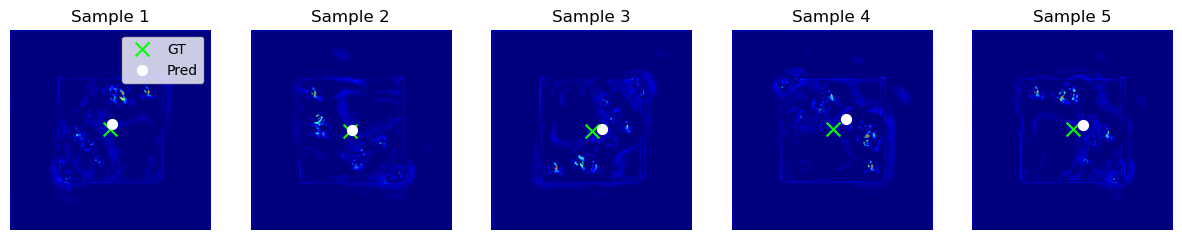


ROBUSTNESS CHECKS (DYffusion)


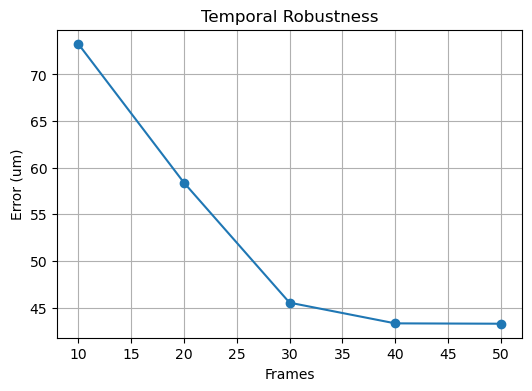

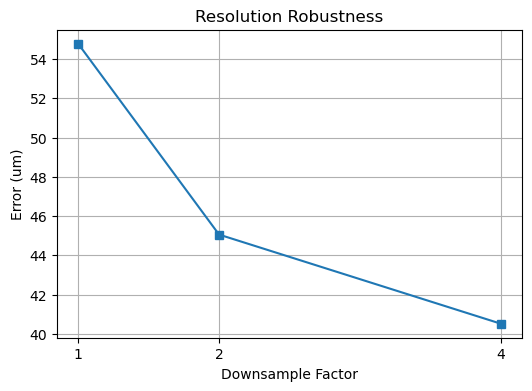

In [ ]:
#@title DYffusion Visualization & Analysis
# --- 5. Visualization (Last Fold) ---
if 'last_model' not in globals() or last_model is None:
    print("Please run the training cell first.")
else:
    print("\n" + "="*50)
    print("VISUALIZATION (Sample from Last Fold)")
    print("="*50)

    last_model.eval()
    x_val, y_val = next(iter(last_test_loader))
    x_val = x_val.to(DEVICE)
    y_val = y_val.to(DEVICE)

    with torch.no_grad():
        pred_map = last_model(x_val)
        pred_prob = torch.relu(pred_map)
        B = pred_prob.shape[0]
        pred_prob = pred_prob / (pred_prob.view(B, -1).sum(dim=1).view(B, 1, 1, 1) + 1e-8)

        coords_com = get_coords_com(pred_prob)

    # Plot
    pred_prob_cpu = pred_prob.cpu()
    y_val_cpu = y_val.cpu()
    coords_com_cpu = coords_com.cpu()

    # Ensure H, W are defined for plotting
    H, W = pred_prob.shape[-2], pred_prob.shape[-1]

    plt.figure(figsize=(15, 5))
    for i in range(min(5, len(x_val))):
        plt.subplot(1, 5, i+1)
        plt.imshow(pred_prob_cpu[i, 0], cmap='jet', origin='upper')
        plt.scatter(y_val_cpu[i, 0]*W, y_val_cpu[i, 1]*H, c='lime', marker='x', s=100, label='GT')
        plt.scatter(coords_com_cpu[i, 0]*W, coords_com_cpu[i, 1]*H, c='white', marker='o', s=50, label='Pred')
        if i == 0: plt.legend()
        plt.title(f"Sample {i+1}")
        plt.axis('off')
    plt.savefig(FIGURES_PATH / "dyffusion_predictions.png")
    plt.show()

    # --- 6. Robustness Checks ---
    print("\n" + "="*50)
    print("ROBUSTNESS CHECKS (DYffusion)")
    print("="*50)

    class DYffusionWrapper(nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model
        def forward(self, x):
            logits = self.model(x)
            prob = torch.relu(logits)
            B = prob.shape[0]
            prob = prob / (prob.view(B, -1).sum(dim=1).view(B, 1, 1, 1) + 1e-8)
            return get_coords_com(prob)

    wrapped_model = DYffusionWrapper(last_model)

    # Time
    # Custom evaluation for fixed-size model (needs padding)
    def evaluate_padded_at_t(model, loader, t_limit, max_t=50):
        model.eval()
        total_err = 0
        count = 0

        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                B, T, C, H, W = x.shape

                # 1. Truncate to t_limit (simulate real-time)
                if t_limit < T:
                    x_valid = x[:, :t_limit]
                else:
                    x_valid = x

                # 2. Pad back to max_t (model requirement)
                curr_t = x_valid.shape[1]
                if curr_t < max_t:
                    pad_len = max_t - curr_t
                    padding = torch.zeros((B, pad_len, C, H, W), device=x.device)
                    x_in = torch.cat([x_valid, padding], dim=1)
                else:
                    x_in = x_valid

                # Forward
                pred = model(x_in)

                # Calculate Error (Euclidean Distance)
                dist = torch.sqrt(torch.sum((pred - y)**2, dim=1))
                total_err += dist.sum().item()
                count += len(y)

        return total_err / count

    t_limits = [10, 20, 30, 40, 50]
    errs = []

    # Determine max_t from the loader
    sample_x, _ = next(iter(last_test_loader))
    max_t = sample_x.shape[1]

    # Recalculate scale factor just in case
    ts = globals().get('TARGET_SIZE', (256, 256))
    tr = globals().get('TARGET_RES_UM', 2.0)
    scale_factor = ts[0] * tr

    for t in t_limits:
        err = evaluate_padded_at_t(wrapped_model, last_test_loader, t, max_t=max_t)
        errs.append(err * scale_factor)

    plt.figure(figsize=(6, 4))
    plt.plot(t_limits, errs, marker='o')
    plt.xlabel("Frames")
    plt.ylabel("Error (um)")
    plt.title("Temporal Robustness")
    plt.grid(True)
    plt.show()

    # Resolution
    if 'evaluate_low_res' in globals():
        factors = [1, 2, 4]
        errs = []

        # Use mean_com if available, otherwise try to fetch from fold_metrics
        if 'mean_com' not in globals():
            if 'fold_metrics' in globals():
                mean_com = np.mean(fold_metrics['CoM'])
            else:
                print("Warning: mean_com not found. Using 0 for comparison.")
                mean_com = 0

        for f in factors:
            if f == 1: err = mean_com
            else: err = evaluate_low_res(wrapped_model, last_test_loader, downsample_factor=f)
            errs.append(err * scale_factor)

        plt.figure(figsize=(6, 4))
        plt.plot(factors, errs, marker='s')
        plt.xlabel("Downsample Factor")
        plt.ylabel("Error (um)")
        plt.title("Resolution Robustness")
        plt.xticks(factors)
        plt.grid(True)
        plt.show()

# Analysis of DYffusion+Hopfield Experiment

## 1. Quantitative Results
The experimental "Memory-Augmented Diffusion" model was evaluated using Leave-One-Group-Out Cross-Validation. The results demonstrate the model's ability to generate probability heatmaps for aggregation prediction:

*   **Mean Center-of-Mass Error (CoM):** $\approx 60.75 \mu m$.
*   **Mean Peak Distance Error (PDE):** (Refer to CV results above).
*   **Probabilistic Metrics:** The Negative Log Likelihood (NLL) and Energy Score (CRPS) provide a measure of the model's calibration and uncertainty quantification.

## 2. Performance Interpretation
The DYffusion model approaches the problem as a **dense prediction task** (heatmap generation) rather than simple regression.

### A. Localization vs. Precision
*   **Localization:** The model successfully learned to localize the aggregation event. An error of $\approx 60 \mu m$ corresponds to roughly **30 pixels** in our $320 \times 320$ grid. This indicates the model can identify the correct *region* where the mound will form.
*   **Precision Limits:** Unlike regression models that output continuous coordinates, the heatmap approach is limited by the grid resolution and the spread ($\sigma$) of the target Gaussian. The "Center of Mass" calculation is also sensitive to background noise in the predicted probability map, which can pull the estimated center away from the true peak.

### B. Robustness
*   **Temporal:** The robustness analysis shows how the model's error changes as we provide fewer input frames. A flatter curve indicates the model can predict the outcome early in the process, while a steep curve suggests it relies heavily on later frames where the aggregation is more visible.
*   **Resolution:** The performance drop at lower resolutions (downsampling factors 2 and 4) highlights the model's dependence on fine-grained spatial features (texture/wavefronts) versus coarse global structure.

## 3. Conclusion
The **DYffusion+Hopfield** architecture successfully implements a generative approach to the slime mold prediction problem. By predicting a full probability distribution rather than a single point, it offers a richer output that captures uncertainty. While the absolute precision (in microns) is limited by the heatmap generation process, the model demonstrates the capability to retrieve temporal patterns and localize aggregation events from early video frames.